최근 온라인 거래를 이용하는 고객들이 많이 늘어나고 있어 고객들의 log 데이터가 많이 늘어나고 있습니다. 온라인 거래 고객 log 데이터를 이용하여 고객들의 미래 소비를 예측 분석프로젝트를 진행하려 합니다.

고객들의 월별 총 구매 금액을 확인했을 때 연말에 소비가 많이 이루어지고 있는 것으로 확인이 되었습니다. 그리하여 12월을 대상으로 고객들에게 프로모션을 통해 성공적인 마케팅을 하기 위해 모델을 만들려고 합니다.

온라인 거래 log 데이터는 2009년 12월부터 2011년 11월까지의 온라인 상점의 거래 데이터가 주어집니다. 2011년 11월 까지 데이터를 이용하여 2011년 12월의 고객 구매액 300초과 여부를 예측해야 합니다.


평가 방법 : AUC Score


<데이터 개요>

고객들의 구입이 이루어질 때 1개의 데이터가 생성이 되며 데이터에는 고객에 대한 정보(고객 id / 고객 거주 국가), 상품 정보(상품 id / 상품 설명 / 상품 가격)와 거래 정보(주문 일자 / 상품 수량)로 2009년 12월 부터 2011년 11월 데이터 까지 학습 데이터셋으로 주어집니다.

데이터 컬럼 설명
- order_id : 주문 번호. 데이터에서 같은 주문번호는 동일 주문을 나타냄
- product_id : 상품 번호
- description : 상품 설명
- quantity : 상품 주문 수량
- order_date : 주문 일자
- price : 상품 가격
- customer_id : 고객 번호
- country : 고객 거주 국가
- total : 총 구매액(quantity X price)

Unique Customer_id : 5914명

Customer 당 로그 수 : 1개 ~ 12714개

제공된 학습 데이터는 2009년 12월 ~ 2011년 11월까지, 테스트셋 데이터는 2011년 12월의 타겟 라벨로 이루어져 있습니다.

5914명의 2009년 12월 ~ 2011년 11월 데이터를 이용하여 각 고객들의 2011년 12월의 총 구매액이 300을 넘을지의 확률값을 예측하는 이진 분류 문제입니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('./train.csv')
test = pd.read_csv('./sample_submission.csv')
train

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.6100
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.6500
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.6500
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.3200
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.5000
...,...,...,...,...,...,...,...,...,...
780497,C579886,22197,POPCORN HOLDER,-1,2011-11-30 17:39:00,1.4025,15676,United Kingdom,-1.4025
780498,C579886,23146,TRIPLE HOOK ANTIQUE IVORY ROSE,-1,2011-11-30 17:39:00,5.4285,15676,United Kingdom,-5.4285
780499,C579887,84946,ANTIQUE SILVER T-LIGHT GLASS,-1,2011-11-30 17:42:00,2.0625,16717,United Kingdom,-2.0625
780500,C579887,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2011-11-30 17:42:00,13.1175,16717,United Kingdom,-13.1175


- data 파악하기

In [2]:
print('Unique Customer_id:', train['customer_id'].nunique())

Unique Customer_id: 5914


In [3]:
print('Customer 당 로그 수:', 
      train.groupby('customer_id')['order_id'].count().min(), 
      '~',
      train.groupby('customer_id')['order_id'].count().max())

Customer 당 로그 수: 1 ~ 12174


In [4]:
print('Date:', train['order_date'].apply(lambda x: x.split('-')[0] + '_' + x.split('-')[1] ).unique())

Date: ['2009_12' '2010_01' '2010_02' '2010_03' '2010_04' '2010_05' '2010_06'
 '2010_07' '2010_08' '2010_09' '2010_10' '2010_11' '2010_12' '2011_01'
 '2011_02' '2011_03' '2011_04' '2011_05' '2011_06' '2011_07' '2011_08'
 '2011_09' '2011_10' '2011_11']


- null 값 확인

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780502 entries, 0 to 780501
Data columns (total 9 columns):
order_id       780502 non-null object
product_id     780502 non-null object
description    780502 non-null object
quantity       780502 non-null int64
order_date     780502 non-null object
price          780502 non-null float64
customer_id    780502 non-null int64
country        780502 non-null object
total          780502 non-null float64
dtypes: float64(2), int64(2), object(5)
memory usage: 53.6+ MB


In [6]:
train['order_id'].unique()

array(['489434', '489435', '489436', ..., '579885', 'C579886', 'C579887'],
      dtype=object)

In [7]:
train['product_id'].unique()

array(['85048', '79323P', '79323W', ..., '23576', '23562', '23561'],
      dtype=object)

In [8]:
train['description'].unique()

array(['15CM CHRISTMAS GLASS BALL 20 LIGHTS', 'PINK CHERRY LIGHTS',
       ' WHITE CHERRY LIGHTS', ..., 'GIN AND TONIC DIET METAL SIGN',
       'SET OF 6 RIBBONS PARTY', 'SILVER AND BLACK ORBIT NECKLACE'],
      dtype=object)

In [9]:
train['order_date'].unique()

array(['2009-12-01 07:45:00', '2009-12-01 07:46:00',
       '2009-12-01 09:06:00', ..., '2011-11-30 17:37:00',
       '2011-11-30 17:39:00', '2011-11-30 17:42:00'], dtype=object)

In [10]:
train['country'].unique()

array(['United Kingdom', 'France', 'USA', 'Belgium', 'Australia', 'EIRE',
       'Germany', 'Portugal', 'Japan', 'Denmark', 'Netherlands', 'Poland',
       'Spain', 'Channel Islands', 'Italy', 'Cyprus', 'Greece', 'Norway',
       'Austria', 'Sweden', 'United Arab Emirates', 'Finland',
       'Switzerland', 'Unspecified', 'Nigeria', 'Malta', 'RSA',
       'Singapore', 'Bahrain', 'Thailand', 'Israel', 'Lithuania',
       'West Indies', 'Korea', 'Brazil', 'Canada', 'Iceland', 'Lebanon',
       'Saudi Arabia', 'Czech Republic', 'European Community'],
      dtype=object)

==> object 유형만 따로 살펴보았는데, 빈값으로 표시되어 있는 컬럼은 없어 보임

- 월 컬럼 생성

In [11]:
train['order_month'] = train['order_date'].apply(lambda x: x.split('-')[0] + '-' + x.split('-')[1])
train['order_month']

0         2009-12
1         2009-12
2         2009-12
3         2009-12
4         2009-12
           ...   
780497    2011-11
780498    2011-11
780499    2011-11
780500    2011-11
780501    2011-11
Name: order_month, Length: 780502, dtype: object

- order_id = 489434인 데이터만 살펴보기

In [12]:
train.loc[train['order_id'] == '489434']

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.610,2009-12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.650,2009-12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.650,2009-12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.320,2009-12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.500,2009-12
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,2.7225,13085,United Kingdom,65.340,2009-12
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.500,2009-12
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,9.8175,13085,United Kingdom,98.175,2009-12


==> 동일한 주문번호를 가지는 행의 수가 여러 개 존재 -> 고객의 각 월별 총 구매액이 300이 넘는가를 구해야하므로 정제가 필요


- customer_id = 13085 데이터만 살펴보기

In [13]:
train.loc[train['customer_id'] == 13085]

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.6100,2009-12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.6500,2009-12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.6500,2009-12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.3200,2009-12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.5000,2009-12
...,...,...,...,...,...,...,...,...,...,...
573895,558996,22617,BAKING SET SPACEBOY DESIGN,3,2011-07-05 12:11:00,8.1675,13085,United Kingdom,24.5025,2011-07
573896,558996,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-07-05 12:11:00,8.1675,13085,United Kingdom,24.5025,2011-07
573897,558996,20749,ASSORTED COLOUR MINI CASES,2,2011-07-05 12:11:00,13.1175,13085,United Kingdom,26.2350,2011-07
573898,558996,22193,RED DINER WALL CLOCK,2,2011-07-05 12:11:00,14.0250,13085,United Kingdom,28.0500,2011-07


In [14]:
# customer_id = 13085의 월별 주문량
train.loc[train['customer_id'] == 13085].groupby('order_month')['order_id'].count()

order_month
2009-12    26
2010-01    36
2010-10     1
2011-02    13
2011-04     7
2011-07     9
Name: order_id, dtype: int64

==> 해당 고객의 구매 이력을 살펴본 결과, 월별 구매량, 구매 시기, 월 구매 빈도, 구매 국가..등을 알 수 있는 변수를 생성하면 좋을 듯 싶음!

- 국가당 구매 횟수 살펴보기

In [15]:
train['country'].value_counts()

United Kingdom          700317
Germany                  16999
EIRE                     15694
France                   13557
Netherlands               5051
Spain                     3683
Switzerland               3058
Belgium                   3012
Portugal                  2312
Australia                 1890
Channel Islands           1640
Italy                     1499
Sweden                    1341
Norway                    1235
Cyprus                    1153
Finland                   1035
Austria                    931
Denmark                    786
Greece                     627
Japan                      557
Poland                     527
Unspecified                521
USA                        492
United Arab Emirates       386
Singapore                  346
Israel                     321
Malta                      294
Canada                     228
Iceland                    211
Lithuania                  154
RSA                        123
Brazil                      94
Thailand

==> United Kingdom의 수가 현저히 많은 것으로 유추해보면, 해당 브랜드가 United Kingdom에 소속되어 있지 않을까..

-> 구매 국가를 United Kingdom 여부로 바꿔서 생각해봐도 되지 않을까...

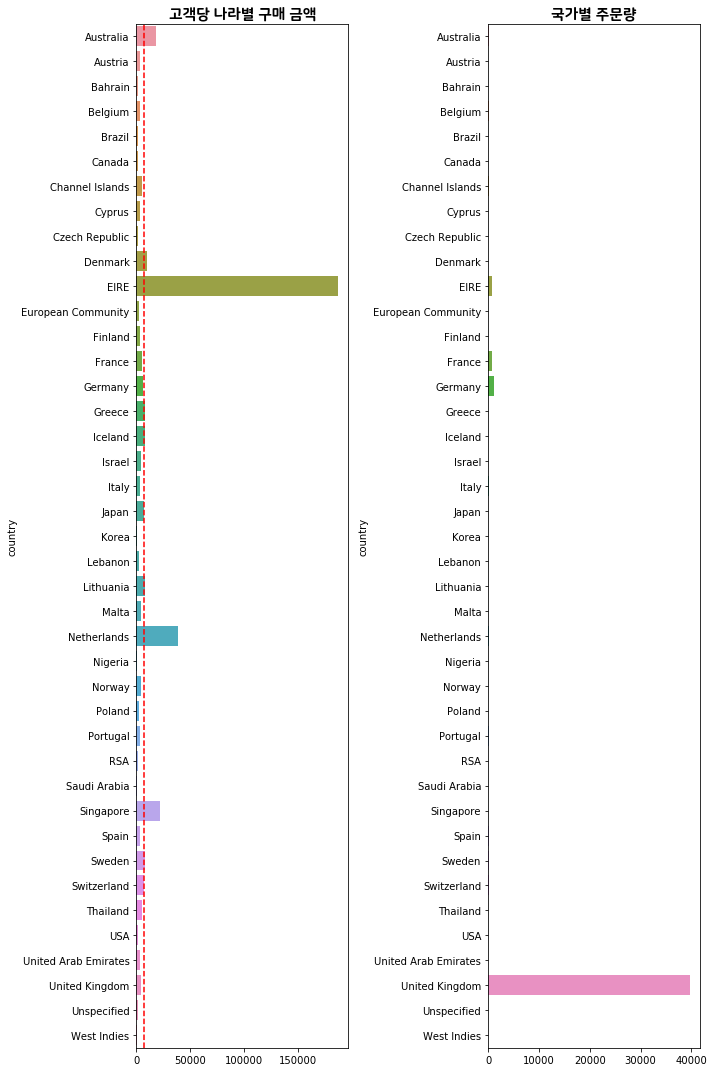

In [16]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

path = 'C:\\Windows\\Fonts\\NanumSquareRoundEB.ttf'
fontprop = fm.FontProperties(fname=path, size=15)

total_per_custom = train.groupby(['country'])['total'].sum()/train.groupby(['country'])['customer_id'].nunique() # 고객당 나라별 구매 금액
country_cnt = train.groupby(['country'])['order_id'].nunique() # 국가별 주문량

fig, ax = plt.subplots(1,2, figsize=(10, 15))
sns.barplot(y = total_per_custom.index, x = total_per_custom.values, ax = ax[0])
ax[0].axvline(300*24, ls='--', color = 'red') 
sns.barplot(y = country_cnt.index, x = country_cnt.values, ax = ax[1])
ax[0].set_title('고객당 나라별 구매 금액', fontproperties = fontprop)
ax[1].set_title('국가별 주문량', fontproperties = fontprop)

fig.tight_layout()


=> 주문량은 United Kingdom에서 많았으나, 실제로 total 금액을 비교해보면 EIRE가 제일 많음... -> 왜일까?...

In [17]:
train.loc[train['country'] == 'EIRE']

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
429,489520,35751C,PURPLE CURRENT CANDLE RING,12,2009-12-01 11:41:00,1.2375,14911,EIRE,14.850,2009-12
430,489520,72739B,WHITE CHOCOLATE SCENT CANDLE,12,2009-12-01 11:41:00,2.0625,14911,EIRE,24.750,2009-12
431,489520,22114,HOT WATER BOTTLE TEA AND SYMPATHY,8,2009-12-01 11:41:00,6.5175,14911,EIRE,52.140,2009-12
432,489520,22212,FOUR HOOK WHITE LOVEBIRDS,6,2009-12-01 11:41:00,3.4650,14911,EIRE,20.790,2009-12
433,489520,21523,FANCY FONT HOME SWEET HOME DOORMAT,2,2009-12-01 11:41:00,11.1375,14911,EIRE,22.275,2009-12
...,...,...,...,...,...,...,...,...,...,...
779956,579768,23382,BOX OF 6 CHRISTMAS CAKE DECORATIONS,8,2011-11-30 15:08:00,6.1875,14911,EIRE,49.500,2011-11
779957,579768,23552,BICYCLE PUNCTURE REPAIR KIT,12,2011-11-30 15:08:00,3.4320,14911,EIRE,41.184,2011-11
779958,579768,23569,TRADTIONAL ALPHABET STAMP SET,12,2011-11-30 15:08:00,8.1675,14911,EIRE,98.010,2011-11
779959,579768,22561,WOODEN SCHOOL COLOURING SET,12,2011-11-30 15:08:00,2.7225,14911,EIRE,32.670,2011-11


In [18]:
train.loc[train['country'] == 'EIRE']['customer_id'].unique()

array([14911, 14156, 14016, 12745, 16047], dtype=int64)

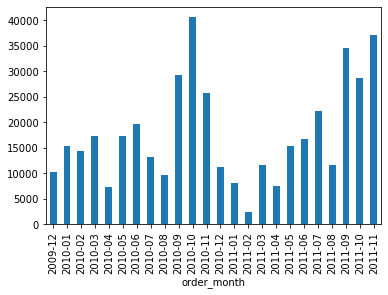

In [19]:
train.loc[(train['country'] == 'EIRE') & (train['customer_id'] == 14911)].groupby('order_month')['total'].sum().plot(kind = 'bar')

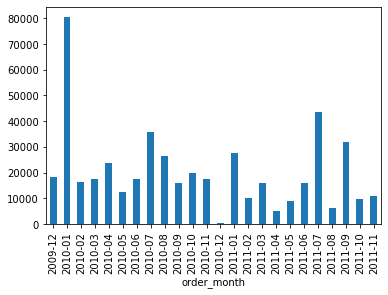

In [20]:
train.loc[(train['country'] == 'EIRE') & (train['customer_id'] == 14156)].groupby('order_month')['total'].sum().plot(kind = 'bar')


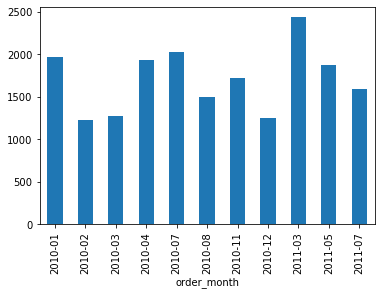

In [21]:
train.loc[(train['country'] == 'EIRE') & (train['customer_id'] == 14016)].groupby('order_month')['total'].sum().plot(kind = 'bar')


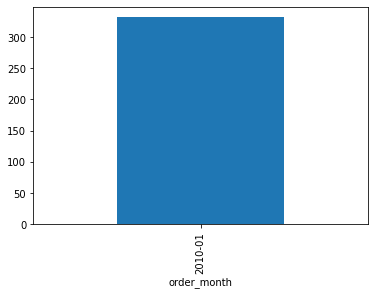

In [22]:
train.loc[(train['country'] == 'EIRE') & (train['customer_id'] == 12745)].groupby('order_month')['total'].sum().plot(kind = 'bar')

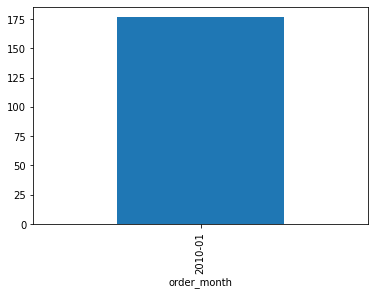

In [23]:
train.loc[(train['country'] == 'EIRE') & (train['customer_id'] == 16047)].groupby('order_month')['total'].sum().plot(kind = 'bar')

=> 예외적으로 EIRE에서 4명의 고객이 달마다 구매금액이 300을 초과함 -> 국가정보 필요없지는 않은듯..


- quantity가 많은 국가는 어디?

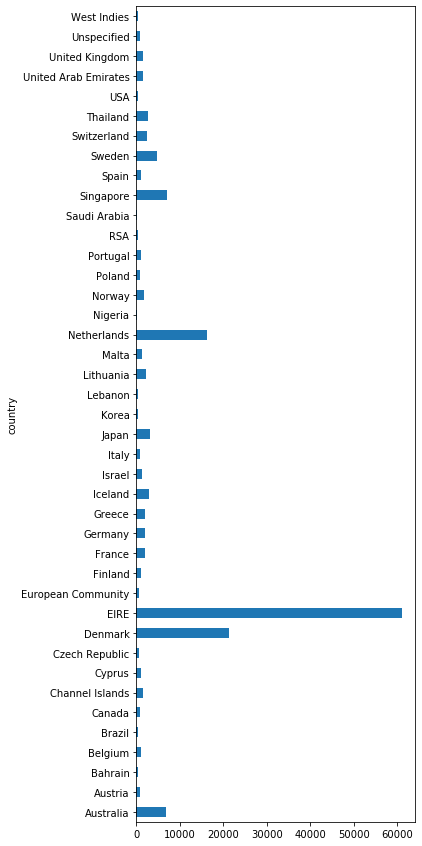

In [24]:
quant_per_custom = train.groupby(['country'])['quantity'].sum()/train.groupby(['country'])['customer_id'].nunique()

plt.figure(figsize = (5, 15))
quant_per_custom.plot(kind = 'barh')

==> 고객당 가장 많이 주문하는 국가는 EIRE! -> 가장 많은 양은 주문한 고객이 있는 나라는?

In [25]:
train.loc[train['quantity'] == train['quantity'].max()]

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
433791,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.716,12346,United Kingdom,127352.94,2011-01


==> United Kingdom에서 quantitiy가 가장 높음 -> 12346의 고객 상세보기

In [26]:
train.loc[train['customer_id'] == 12346]

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
21447,491725,TEST001,This is a test product.,10,2009-12-14 08:34:00,7.4250,12346,United Kingdom,74.2500,2009-12
21702,491742,TEST001,This is a test product.,5,2009-12-14 11:00:00,7.4250,12346,United Kingdom,37.1250,2009-12
21705,491744,TEST001,This is a test product.,5,2009-12-14 11:02:00,7.4250,12346,United Kingdom,37.1250,2009-12
28492,492718,TEST001,This is a test product.,5,2009-12-18 10:47:00,7.4250,12346,United Kingdom,37.1250,2009-12
28504,492722,TEST002,This is a test product.,1,2009-12-18 10:55:00,1.6500,12346,United Kingdom,1.6500,2009-12
31276,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,7.4250,12346,United Kingdom,37.1250,2010-01
31278,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,7.4250,12346,United Kingdom,37.1250,2010-01
37892,494450,TEST001,This is a test product.,5,2010-01-14 13:50:00,7.4250,12346,United Kingdom,37.1250,2010-01
44909,495295,TEST001,This is a test product.,5,2010-01-22 13:30:00,7.4250,12346,United Kingdom,37.1250,2010-01
49055,C495800,ADJUST,Adjustment by john on 26/01/2010 17,-1,2010-01-26 17:27:00,170.7750,12346,United Kingdom,-170.7750,2010-01


==> product_id == M 확인

==> 고객의 할인받은 이력은 product_id == D 확인하면 될듯... -> 할인받은 이력 변수를 도출하면 될듯

==> product_id == ADJUST 확인해보기

==> this is a test product는 제거할 필요가 있어보임

==> customer_id == 12346 관리자 계정?? -> 확인요망

In [27]:
train.loc[train['order_id'] == 'C525274']

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
291616,C525274,TEST001,This is a test product.,-1,2010-10-04 16:33:00,7.425,12346,United Kingdom,-7.425,2010-10


==> total값이 -만 존재 -> product_id가 TEST로 시작되는 데이터를 살펴보자

In [28]:
train.loc[train['product_id'].str.startswith('TEST')]

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
21447,491725,TEST001,This is a test product.,10,2009-12-14 08:34:00,7.425,12346,United Kingdom,74.250,2009-12
21702,491742,TEST001,This is a test product.,5,2009-12-14 11:00:00,7.425,12346,United Kingdom,37.125,2009-12
21705,491744,TEST001,This is a test product.,5,2009-12-14 11:02:00,7.425,12346,United Kingdom,37.125,2009-12
28492,492718,TEST001,This is a test product.,5,2009-12-18 10:47:00,7.425,12346,United Kingdom,37.125,2009-12
28504,492722,TEST002,This is a test product.,1,2009-12-18 10:55:00,1.650,12346,United Kingdom,1.650,2009-12
31276,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,7.425,12346,United Kingdom,37.125,2010-01
31278,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,7.425,12346,United Kingdom,37.125,2010-01
37892,494450,TEST001,This is a test product.,5,2010-01-14 13:50:00,7.425,12346,United Kingdom,37.125,2010-01
44909,495295,TEST001,This is a test product.,5,2010-01-22 13:30:00,7.425,12346,United Kingdom,37.125,2010-01
62932,497819,TEST001,This is a test product.,5,2010-02-12 14:58:00,0.000,14103,United Kingdom,0.000,2010-02


==> Quantity가 증가없이 감소하는 것으로 보아 시스템 확인차 수행하지 않았을까.. -> customer_id를 확인해볼 필요가 있을듯

In [29]:
train.loc[train['product_id'].str.startswith('TEST')]['customer_id'].unique()

array([12346, 14103, 14827, 16454, 16446], dtype=int64)

==> product_id가 TEST로 되어있는 customer_id가 관리자 계정으로 보임

- 관리자 계정 확인

In [30]:
train.loc[train['customer_id'] == 12346]

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
21447,491725,TEST001,This is a test product.,10,2009-12-14 08:34:00,7.4250,12346,United Kingdom,74.2500,2009-12
21702,491742,TEST001,This is a test product.,5,2009-12-14 11:00:00,7.4250,12346,United Kingdom,37.1250,2009-12
21705,491744,TEST001,This is a test product.,5,2009-12-14 11:02:00,7.4250,12346,United Kingdom,37.1250,2009-12
28492,492718,TEST001,This is a test product.,5,2009-12-18 10:47:00,7.4250,12346,United Kingdom,37.1250,2009-12
28504,492722,TEST002,This is a test product.,1,2009-12-18 10:55:00,1.6500,12346,United Kingdom,1.6500,2009-12
31276,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,7.4250,12346,United Kingdom,37.1250,2010-01
31278,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,7.4250,12346,United Kingdom,37.1250,2010-01
37892,494450,TEST001,This is a test product.,5,2010-01-14 13:50:00,7.4250,12346,United Kingdom,37.1250,2010-01
44909,495295,TEST001,This is a test product.,5,2010-01-22 13:30:00,7.4250,12346,United Kingdom,37.1250,2010-01
49055,C495800,ADJUST,Adjustment by john on 26/01/2010 17,-1,2010-01-26 17:27:00,170.7750,12346,United Kingdom,-170.7750,2010-01


In [31]:
train.loc[train['customer_id'] == 12346].groupby('order_month')['total'].sum()

order_month
2009-12    187.2750
2010-01    -22.2750
2010-03     44.6325
2010-06   -285.9285
2010-10     -9.0750
2011-01      0.0000
Name: total, dtype: float64

=> 월별 구매금액이 -가 나오는 것은 말이 안됨 -> 처리가 필요

In [32]:
train.loc[train['customer_id'] == 14103]

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
62932,497819,TEST001,This is a test product.,5,2010-02-12 14:58:00,0.0,14103,United Kingdom,0.0,2010-02


In [33]:
train.loc[train['customer_id'] == 14827]

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
63021,497843,TEST001,This is a test product.,5,2010-02-12 15:47:00,0.0,14827,United Kingdom,0.0,2010-02


In [34]:
train.loc[train['customer_id'] == 16454]

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
55361,C496598,POST,POSTAGE,-1,2010-02-02 16:18:00,8.2500,16454,United Kingdom,-8.2500,2010-02
112883,503830,46000M,POLYESTER FILLER PAD 45x45cm,1,2010-04-07 15:54:00,2.5575,16454,United Kingdom,2.5575,2010-04
116368,504188,TEST001,This is a test product.,5,2010-04-12 09:52:00,7.4250,16454,United Kingdom,37.1250,2010-04
291614,C525272,TEST001,This is a test product.,-1,2010-10-04 16:29:00,7.4250,16454,United Kingdom,-7.4250,2010-10
291615,C525273,TEST001,This is a test product.,-1,2010-10-04 16:30:00,7.4250,16454,United Kingdom,-7.4250,2010-10
502533,C549930,M,Manual,-1,2011-04-13 10:36:00,24.8325,16454,United Kingdom,-24.8325,2011-04
676041,569915,90012A,MIDNIGHT BLUE DROP CRYSTAL NECKLACE,2,2011-10-06 16:57:00,4.8675,16454,United Kingdom,9.7350,2011-10
706424,572832,M,Manual,1,2011-10-26 11:40:00,1.6500,16454,United Kingdom,1.6500,2011-10


In [35]:
train.loc[train['customer_id'] == 16454].groupby('order_month')['total'].sum()

order_month
2010-02    -8.2500
2010-04    39.6825
2010-10   -14.8500
2011-04   -24.8325
2011-10    11.3850
Name: total, dtype: float64

In [36]:
train.loc[train['customer_id'] == 16446]

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
291617,C525275,TEST001,This is a test product.,-2,2010-10-04 16:38:00,7.4250,16446,United Kingdom,-14.8500,2010-10
531730,553573,22980,PANTRY SCRUBBING BRUSH,1,2011-05-18 09:52:00,2.7225,16446,United Kingdom,2.7225,2011-05
531731,553573,22982,PANTRY PASTRY BRUSH,1,2011-05-18 09:52:00,2.0625,16446,United Kingdom,2.0625,2011-05


In [37]:
train.loc[train['customer_id'] == 16446].groupby('order_month')['total'].sum()

order_month
2010-10   -14.850
2011-05     4.785
Name: total, dtype: float64

==> 관리자 계정으로 칭한 것의 값들이 이상치로 보이나, submission에 해당 id가 포함되어있는지 확인 필요

In [38]:
for custom_id in test['customer_id']:
    if custom_id in [12346, 14103, 14827, 16454, 16446]:
        print('{} 관리자 계정이 포함되어있습니다.'.format(custom_id))

12346 관리자 계정이 포함되어있습니다.
14103 관리자 계정이 포함되어있습니다.
14827 관리자 계정이 포함되어있습니다.
16446 관리자 계정이 포함되어있습니다.
16454 관리자 계정이 포함되어있습니다.


==> 무작정 삭제할 수는 없으므로, 대부분 이력이 구입 이력보다는 테스트 이력으로 보임 -> 관리자 계정은 추후 0으로 예측하는 편이 좋지 않을까...
-> 우선 학습용 데이터셋에서 해당 customer_id 제거

In [39]:
supervisor = [12346, 14103, 14827, 16454, 16446] 
train = train.loc[train['customer_id'].apply(lambda x: x not in supervisor)]
train

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.6100,2009-12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.6500,2009-12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.6500,2009-12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.3200,2009-12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.5000,2009-12
...,...,...,...,...,...,...,...,...,...,...
780497,C579886,22197,POPCORN HOLDER,-1,2011-11-30 17:39:00,1.4025,15676,United Kingdom,-1.4025,2011-11
780498,C579886,23146,TRIPLE HOOK ANTIQUE IVORY ROSE,-1,2011-11-30 17:39:00,5.4285,15676,United Kingdom,-5.4285,2011-11
780499,C579887,84946,ANTIQUE SILVER T-LIGHT GLASS,-1,2011-11-30 17:42:00,2.0625,16717,United Kingdom,-2.0625,2011-11
780500,C579887,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2011-11-30 17:42:00,13.1175,16717,United Kingdom,-13.1175,2011-11


==> product_id 시작이 숫자가 아닌 것 살펴보기

In [40]:
train['product_id'].sort_values().unique()

array(['10002', '10080', '10109', ..., 'PADS', 'POST', 'SP1002'],
      dtype=object)

In [41]:
train.loc[train['product_id'].str.contains(r'^[a-zA-Z]')]

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
89,489439,POST,POSTAGE,3,2009-12-01 09:28:00,29.7000,12682,France,89.1000,2009-12
126,489444,POST,POSTAGE,1,2009-12-01 09:55:00,232.6500,12636,USA,232.6500,2009-12
173,489447,POST,POSTAGE,1,2009-12-01 10:10:00,214.5000,12362,Belgium,214.5000,2009-12
611,489526,POST,POSTAGE,6,2009-12-01 11:50:00,29.7000,12533,Germany,178.2000,2009-12
716,C489535,D,Discount,-1,2009-12-01 12:11:00,14.8500,15299,United Kingdom,-14.8500,2009-12
...,...,...,...,...,...,...,...,...,...,...
779988,579786,POST,POSTAGE,2,2011-11-30 15:31:00,29.7000,12524,Germany,59.4000,2011-11
779995,579790,POST,POSTAGE,2,2011-11-30 15:38:00,46.2000,12784,Portugal,92.4000,2011-11
780064,579792,POST,POSTAGE,5,2011-11-30 15:43:00,29.7000,12714,France,148.5000,2011-11
780273,579870,POST,POSTAGE,2,2011-11-30 16:47:00,29.7000,12437,France,59.4000,2011-11


In [42]:
train.loc[train['product_id'].str.contains(r'^[a-zA-Z]')]['product_id'].unique()

array(['POST', 'D', 'M', 'C2', 'BANK CHARGES', 'PADS', 'ADJUST',
       'ADJUST2', 'SP1002', 'DOT', 'CRUK'], dtype=object)

In [43]:
train.loc[train['product_id'] == 'POST'] 

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
89,489439,POST,POSTAGE,3,2009-12-01 09:28:00,29.700,12682,France,89.100,2009-12
126,489444,POST,POSTAGE,1,2009-12-01 09:55:00,232.650,12636,USA,232.650,2009-12
173,489447,POST,POSTAGE,1,2009-12-01 10:10:00,214.500,12362,Belgium,214.500,2009-12
611,489526,POST,POSTAGE,6,2009-12-01 11:50:00,29.700,12533,Germany,178.200,2009-12
893,C489538,POST,POSTAGE,-1,2009-12-01 12:18:00,15.807,15796,United Kingdom,-15.807,2009-12
...,...,...,...,...,...,...,...,...,...,...
779836,579747,POST,POSTAGE,3,2011-11-30 14:40:00,29.700,12528,Germany,89.100,2011-11
779988,579786,POST,POSTAGE,2,2011-11-30 15:31:00,29.700,12524,Germany,59.400,2011-11
779995,579790,POST,POSTAGE,2,2011-11-30 15:38:00,46.200,12784,Portugal,92.400,2011-11
780064,579792,POST,POSTAGE,5,2011-11-30 15:43:00,29.700,12714,France,148.500,2011-11


==> 우편요금 추가 -> post가 있는 나라 살펴보기

In [44]:
train.loc[train['product_id'] == 'POST']['country'].unique()

array(['France', 'USA', 'Belgium', 'Germany', 'United Kingdom',
       'Netherlands', 'Spain', 'Norway', 'Portugal', 'Finland', 'Denmark',
       'Switzerland', 'Austria', 'Sweden', 'Italy', 'EIRE', 'Greece',
       'Cyprus', 'Poland', 'United Arab Emirates', 'Australia',
       'European Community', 'Malta', 'Canada', 'Czech Republic'],
      dtype=object)

In [45]:
print('총 나라 수: {}, post 요금을 지불하는 나라 수: {}'.format(train['country'].nunique(),
train.loc[train['product_id'] == 'POST']['country'].nunique()))

총 나라 수: 41, post 요금을 지불하는 나라 수: 25


==> 모든 나라가 post 금액을 지불하는 것은 아닌듯.. -> 기준이 무엇일까.. -> 나라별 post 금액 살펴보기

In [46]:
# 구매 나라 프랑스에서 지불한 post 금액
train.loc[(train['product_id'] == 'POST') & (train['country'] == 'France')]['price'].value_counts()

29.70     445
1.65        4
24.75       4
239.25      3
18.15       1
84.15       1
163.35      1
221.10      1
28.05       1
272.25      1
33.00       1
8.25        1
297.00      1
Name: price, dtype: int64

==> 대부분 29.70을 지불함 -> 그외 가격은 왜 발생했는지 살펴보기

In [47]:
pst_order_id = train.loc[(train['product_id'] == 'POST') & (train['country'] == 'France') & (train['price'] != 29.70)]['order_id'].unique()
print('order_id list: {}'.format(pst_order_id))
train.loc[train['order_id'].apply(lambda x: x in pst_order_id)]

order_id list: ['493924' '496916' '505555' '509985' '510668' '510824' '518007' '521037'
 'C525190' '526965' 'C527020' '533952' '548725' 'C550365' '551649'
 '551652' '559889' '562207' '564862' '573153']


,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
34349,493924,POST,POSTAGE,1,2010-01-08 11:25:00,297.0000,12678,France,297.0000,2010-01
57308,496916,POST,POSTAGE,1,2010-02-04 15:33:00,84.1500,12490,France,84.1500,2010-02
127866,505555,22073,RED RETROSPOT STORAGE JAR,4,2010-04-23 09:57:00,6.1875,12672,France,24.7500,2010-04
127867,505555,47566,PARTY BUNTING,5,2010-04-23 09:57:00,7.6725,12672,France,38.3625,2010-04
127868,505555,20718,RED SPOTTY SHOPPER BAG,10,2010-04-23 09:57:00,2.0625,12672,France,20.6250,2010-04
...,...,...,...,...,...,...,...,...,...,...
710218,573153,23493,VINTAGE DOILY TRAVEL SEWING KIT,24,2011-10-28 07:39:00,3.2175,12678,France,77.2200,2011-10
710219,573153,23382,BOX OF 6 CHRISTMAS CAKE DECORATIONS,72,2011-10-28 07:39:00,5.4285,12678,France,390.8520,2011-10
710220,573153,POST,POSTAGE,3,2011-10-28 07:39:00,239.2500,12678,France,717.7500,2011-10
710221,573153,22727,ALARM CLOCK BAKELIKE RED,48,2011-10-28 07:39:00,6.1875,12678,France,297.0000,2011-10


==> 구입한 물품없이 배송비만 존재하는게 가능한가? -> 주문한 이력 살펴보기

In [48]:
train.loc[train['order_id'].apply(lambda x: x in pst_order_id)].groupby(['order_id'])['product_id'].count()

order_id
493924      1
496916      1
505555     12
509985     21
510668      1
510824      1
518007     10
521037      1
526965     29
533952      8
548725      1
551649      4
551652      5
559889     10
562207      8
564862      1
573153     61
C525190     1
C527020    29
C550365     2
Name: product_id, dtype: int64

==> count = 1인 order_id 살펴보자

In [49]:
tmp = train.loc[train['order_id'].apply(lambda x: x in pst_order_id)].groupby(['order_id'])['product_id'].count() 
cnt_one_idx = tmp[tmp == 1].index
train.loc[train['order_id'].apply(lambda x: x in cnt_one_idx)]

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
34349,493924,POST,POSTAGE,1,2010-01-08 11:25:00,297.00,12678,France,297.00,2010-01
57308,496916,POST,POSTAGE,1,2010-02-04 15:33:00,84.15,12490,France,84.15,2010-02
167601,510668,POST,POSTAGE,2,2010-06-02 15:03:00,28.05,12681,France,56.10,2010-06
169112,510824,POST,POSTAGE,1,2010-06-03 19:57:00,24.75,12643,France,24.75,2010-06
252387,521037,POST,POSTAGE,1,2010-09-02 09:14:00,163.35,12678,France,163.35,2010-09
290787,C525190,POST,POSTAGE,-1,2010-10-04 12:32:00,8.25,12681,France,-8.25,2010-10
493813,548725,POST,POSTAGE,1,2011-04-04 09:08:00,221.10,12678,France,221.10,2011-04
625161,564862,POST,POSTAGE,1,2011-08-31 10:24:00,239.25,12678,France,239.25,2011-08


==> customer_id와 order_date와 함께 살펴보자

In [50]:
train.loc[(train['customer_id'] == 12678) & (train['order_date'].str.startswith('2010-01'))]

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
33872,493863,21980,PACK OF 12 RED SPOTTY TISSUES,48,2010-01-07 16:46:00,0.4785,12678,France,22.968,2010-01
33873,493863,21985,PACK OF 12 HEARTS DESIGN TISSUES,48,2010-01-07 16:46:00,0.4785,12678,France,22.968,2010-01
33874,493863,21080,SET/20 RED SPOTTY PAPER NAPKINS,54,2010-01-07 16:46:00,1.4025,12678,France,75.735,2010-01
33875,493863,21086,SET/6 RED SPOTTY PAPER CUPS,72,2010-01-07 16:46:00,1.0725,12678,France,77.220,2010-01
33876,493863,21094,SET/6 RED SPOTTY PAPER PLATES,72,2010-01-07 16:46:00,1.4025,12678,France,100.980,2010-01
33877,493863,21358,TOAST ITS - HAPPY BIRTHDAY,12,2010-01-07 16:46:00,2.0625,12678,France,24.750,2010-01
33878,493863,21949,SET OF 6 STRAWBERRY CHOPSTICKS,48,2010-01-07 16:46:00,2.0625,12678,France,99.000,2010-01
33879,493863,85217,ASSORTED ICE CREAM FRIDGE MAGNETS,96,2010-01-07 16:46:00,1.0725,12678,France,102.960,2010-01
33880,493863,85216,ASSORTED CAKES FRIDGE MAGNETS,96,2010-01-07 16:46:00,1.0725,12678,France,102.960,2010-01
33881,493863,84997C,BLUE 3 PIECE MINI DOTS CUTLERY SET,12,2010-01-07 16:46:00,6.1875,12678,France,74.250,2010-01


==> 물품없이 배송비만 청구된 건은 청구되지 않은 건에 대해 다음날 청구된 것으로 보임 -> 직관적으로 post 금액은 주문한 물품 수(물품 수 증가 -> 무게 증가)와 관련있을 것으로 예상되어지는데...실제로도 그러한가?

In [51]:
train.loc[(train['order_id'] == '493863') & (train['product_id'] == 'POST')]

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month


In [52]:
print('order_id = 493863의 post 금액으로 추정되는 493924의 post 금액: {}'.format(train.loc[(train['order_id'] == '493924') & (train['product_id'] == 'POST')]['total'].sum()))


order_id = 493863의 post 금액으로 추정되는 493924의 post 금액: 297.0


In [53]:
print('order_id = 493863의 주문한 물품 수: {}'.format(sum(train.loc[(train['order_id'] == '493863')]['quantity'])))

order_id = 493863의 주문한 물품 수: 1888


In [54]:
print('order_id = 493863의 주문한 금액: {}'.format(sum(train.loc[(train['order_id'] == '493863')]['total'])))

order_id = 493863의 주문한 금액: 3514.995


In [55]:
1888/297.0

6.356902356902357

==> 주문 물량과 금액 모두 높아서 post 금액에 영향을 주는 요인을 알 수 없음 -> 기본료로 보이는 29.7의 경우 물품의 개수가 몇개인지 살펴보자

In [56]:
train.loc[(train['price'] == 29.70)]['order_id'] 

89         489439
611        489526
1154       489557
2502      C489685
4445       489883
           ...   
779675     579708
779836     579747
779988     579786
780064     579792
780273     579870
Name: order_id, Length: 1137, dtype: object

==> order_id = 489439만 따로 살펴보자

In [57]:
train.loc[(train['order_id'] == '489439')]

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
71,489439,22065,CHRISTMAS PUDDING TRINKET POT,12,2009-12-01 09:28:00,2.3925,12682,France,28.7100,2009-12
72,489439,22138,BAKING SET 9 PIECE RETROSPOT,9,2009-12-01 09:28:00,8.1675,12682,France,73.5075,2009-12
73,489439,22139,RETRO SPOT TEA SET CERAMIC 11 PC,9,2009-12-01 09:28:00,8.1675,12682,France,73.5075,2009-12
74,489439,22352,LUNCHBOX WITH CUTLERY RETROSPOT,12,2009-12-01 09:28:00,4.2075,12682,France,50.4900,2009-12
75,489439,85014A,BLACK/BLUE DOTS RUFFLED UMBRELLA,3,2009-12-01 09:28:00,9.8175,12682,France,29.4525,2009-12
76,489439,85014B,RED/WHITE DOTS RUFFLED UMBRELLA,3,2009-12-01 09:28:00,9.8175,12682,France,29.4525,2009-12
77,489439,16161P,WRAP ENGLISH ROSE,25,2009-12-01 09:28:00,0.6930,12682,France,17.3250,2009-12
78,489439,16169N,WRAP BLUE RUSSIAN FOLKART,25,2009-12-01 09:28:00,0.6930,12682,France,17.3250,2009-12
79,489439,21491,SET OF THREE VINTAGE GIFT WRAPS,6,2009-12-01 09:28:00,3.2175,12682,France,19.3050,2009-12
80,489439,22333,RETRO SPORT PARTY BAG + STICKER SET,8,2009-12-01 09:28:00,2.7225,12682,France,21.7800,2009-12


In [58]:
print('order_id = 489439의 post 금액: {}'.format(train.loc[(train['order_id'] == '489439') & (train['product_id'] == 'POST')]['total'].sum()))


order_id = 489439의 post 금액: 89.1


In [59]:
print('order_id = 489439의 주문한 물품 수: {}'.format(sum(train.loc[(train['order_id'] == '489439')]['quantity'])))

order_id = 489439의 주문한 물품 수: 219


In [60]:
print('order_id = 489439의 주문한 금액: {}'.format(sum(train.loc[(train['order_id'] == '489439')]['total'])))

order_id = 489439의 주문한 금액: 703.3950000000001


In [61]:
219/89.1

2.457912457912458

==> 다른 주문번호도 살펴보자 -> 489526

In [62]:
print('order_id = 489526의 post 금액: {}'.format(train.loc[(train['order_id'] == '489526') & (train['product_id'] == 'POST')]['total'].sum()))


order_id = 489526의 post 금액: 178.2


In [63]:
print('order_id = 489526의 주문한 물품 수: {}'.format(sum(train.loc[(train['order_id'] == '489526')]['quantity'])))

order_id = 489526의 주문한 물품 수: 484


In [64]:
print('order_id = 489526의 주문한 금액: {}'.format(sum(train.loc[(train['order_id'] == '489526')]['total'])))

order_id = 489526의 주문한 금액: 1534.3680000000004


In [65]:
484/178.2

2.7160493827160495

==> 다른 주문번호도 살펴보자 -> 528325

In [66]:
print('order_id = 528325의 주문한 물품 수: {}'.format(train.loc[(train['order_id'] == '489526') & (train['product_id'] == 'POST')]['total'].sum()))


order_id = 528325의 주문한 물품 수: 178.2


In [67]:
print('order_id = 528325의 주문한 물품 수: {}'.format(sum(train.loc[(train['order_id'] == '528325')]['quantity'])))

order_id = 528325의 주문한 물품 수: 312


In [68]:
print('order_id = 528325의 주문한 금액: {}'.format(sum(train.loc[(train['order_id'] == '528325')]['total'])))

order_id = 528325의 주문한 금액: 1127.2140000000002


In [69]:
312/178.2

1.7508417508417509

==> 잘모르겠음 -> 일단은 물량과 금액에 관한 변수 생성하는걸로...

In [70]:
# order_id에 따른 post 금액과 post 금액을 제외한 총 구매금액 산출
tmp = pd.concat([train.loc[train['product_id'] == 'POST'].groupby(['order_id'])['total'].mean(),
                train.loc[train['product_id'] != 'POST'].groupby(['order_id'])['quantity'].sum(),
                train.loc[train['product_id'] != 'POST'].groupby(['order_id'])['total'].sum()], keys = ['post_price', 'total_quantity', 'total_price'], axis = 1)           
tmp

C:\Users\seung\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


,post_price,total_quantity,total_price
489434,NaN,166.0,833.7450
489435,NaN,60.0,240.5700
489436,NaN,193.0,1040.0445
489437,NaN,145.0,512.7375
489438,NaN,826.0,3772.2960
...,...,...,...
C579882,NaN,-7.0,-24.5025
C579883,NaN,-5.0,-31.5975
C579884,NaN,-1.0,-33.8745
C579886,NaN,-17.0,-150.5955


=> post 금액이 없는 나라도 존재하므로 na를 제거하고 살펴보자

In [71]:
tmp[(tmp['post_price'].notnull()) & (tmp['total_price'].notnull())]

,post_price,total_quantity,total_price
489439,89.1000,216.0,614.2950
489526,178.2000,478.0,1356.1680
489557,118.8000,438.0,877.7010
489883,89.1000,260.0,865.0620
490152,207.9000,231.0,918.4725
...,...,...,...
C569733,-29.7000,-2.0,-19.6350
C574875,-7.2765,-16.0,-33.0000
C579092,-7.2765,-108.0,-21.3840
C579192,-118.8000,-386.0,-691.5480


==> 유추하기 힘듦 -> pass

In [72]:
train.loc[(train['product_id'] == 'POST') & (train['country'] == 'USA')]['price'].value_counts()

232.65    1
280.50    1
214.50    1
8.25      1
Name: price, dtype: int64

In [73]:
train.loc[(train['product_id'] == 'POST') & (train['country'] == 'Belgium')]['price'].value_counts()

24.75     122
29.70      17
4.95        1
239.25      1
330.00      1
214.50      1
Name: price, dtype: int64

In [74]:
train.loc[(train['product_id'] == 'POST') & (train['country'] == 'Germany')]['price'].value_counts()

29.7000     617
1.6500        4
18.0675       2
28.0500       1
478.5000      1
862.9500      1
504.9000      1
356.4000      1
396.0000      1
24.7500       1
239.2500      1
Name: price, dtype: int64

In [75]:
train.loc[(train['product_id'] == 'POST') & (train['country'] == 'United Kingdom')]['price'].value_counts()

24.7500      16
7.2765       12
11.6490       7
8.1675        6
8.2500        5
             ..
6.3030        1
1228.4910     1
39.6000       1
7.0125        1
9.4710        1
Name: price, Length: 82, dtype: int64

In [76]:
train.loc[(train['product_id'] == 'POST') & (train['country'] == 'Netherlands')]['price'].value_counts()

24.75     86
29.70     14
1.65       1
470.25     1
4.95       1
Name: price, dtype: int64

In [77]:
train.loc[(train['product_id'] == 'POST') & (train['country'] == 'Spain')]['price'].value_counts()

46.2000     94
288.3375     1
29.7000      1
363.0000     1
41.2500      1
379.5000     1
266.0625     1
Name: price, dtype: int64

In [78]:
train.loc[(train['product_id'] == 'POST') & (train['country'] == 'Norway')]['price'].value_counts()

66.000      17
9.900        1
7.425        1
1155.000     1
Name: price, dtype: int64

In [79]:
train.loc[(train['product_id'] == 'POST') & (train['country'] == 'Portugal')]['price'].value_counts()

46.20     44
29.70      2
44.55      1
1.65       1
197.34     1
Name: price, dtype: int64

In [80]:
train.loc[(train['product_id'] == 'POST') & (train['country'] == 'Finland')]['price'].value_counts()

66.00    42
29.70     3
1.65      1
Name: price, dtype: int64

In [81]:
train.loc[(train['product_id'] == 'POST') & (train['country'] == 'Denmark')]['price'].value_counts()

29.70    21
24.75     2
Name: price, dtype: int64

In [82]:
train.loc[(train['product_id'] == 'POST') & (train['country'] == 'Switzerland')]['price'].value_counts()

66.00      50
29.70       4
1.65        2
1402.50     1
57.75       1
Name: price, dtype: int64

In [83]:
train.loc[(train['product_id'] == 'POST') & (train['country'] == 'Austria')]['price'].value_counts()

66.0    32
46.2     1
Name: price, dtype: int64

In [84]:
train.loc[(train['product_id'] == 'POST') & (train['country'] == 'Sweden')]['price'].value_counts()

66.000     44
29.700      4
57.750      2
86.559      1
24.750      1
462.000     1
Name: price, dtype: int64

In [85]:
train.loc[(train['product_id'] == 'POST') & (train['country'] == 'Italy')]['price'].value_counts()

46.20     17
66.00      5
57.75      3
29.70      2
495.00     1
412.50     1
330.00     1
363.00     1
Name: price, dtype: int64

In [86]:
train.loc[(train['product_id'] == 'POST') & (train['country'] == 'EIRE')]['price'].value_counts()

41.25    1
Name: price, dtype: int64

In [87]:
train.loc[(train['product_id'] == 'POST') & (train['country'] == 'Greece')]['price'].value_counts()

82.5    4
Name: price, dtype: int64

In [88]:
train.loc[(train['product_id'] == 'POST') & (train['country'] == 'Cyprus')]['price'].value_counts()

24.75    3
Name: price, dtype: int64

In [89]:
train.loc[(train['product_id'] == 'POST') & (train['country'] == 'Poland')]['price'].value_counts()

66.0    6
Name: price, dtype: int64

In [90]:
train.loc[(train['product_id'] == 'POST') & (train['country'] == 'United Arab Emirates')]['price'].value_counts()

61.875    1
24.750    1
Name: price, dtype: int64

In [91]:
train.loc[(train['product_id'] == 'POST') & (train['country'] == 'Australia')]['price'].value_counts()

433.5045    1
577.5000    1
Name: price, dtype: int64

In [92]:
train.loc[(train['product_id'] == 'POST') & (train['country'] == 'European Community')]['price'].value_counts()

24.75    2
29.70    1
Name: price, dtype: int64

In [93]:
train.loc[(train['product_id'] == 'POST') & (train['country'] == 'Malta')]['price'].value_counts()

107.25    2
66.00     2
Name: price, dtype: int64

In [94]:
train.loc[(train['product_id'] == 'POST') & (train['country'] == 'Canada')]['price'].value_counts()

909.051    1
Name: price, dtype: int64

In [95]:
train.loc[(train['product_id'] == 'POST') & (train['country'] == 'Czech Republic')]['price'].value_counts()

6.6     1
66.0    1
Name: price, dtype: int64

=> 고객당 월 평균 post 지불 금액 or 자주 지불하는 post 금액으로 데이터셋을 구성하면 될듯 -> 고객별 post 금액 확인

- 고객별 post 살펴보기

In [96]:
train.loc[(train['product_id'] == 'POST')].groupby(['customer_id'])['total'].describe()

,count,mean,std,min,25%,50%,75%,max
customer_id,,,,,,,,
12348,5.0,119.13000,157.263265,1.6500,66.000000,66.00000,66.000000,396.0000
12349,3.0,412.50000,82.500000,330.0000,371.250000,412.50000,453.750000,495.0000
12350,1.0,66.00000,NaN,66.0000,66.000000,66.00000,66.000000,66.0000
12352,5.0,92.40000,36.149689,66.0000,66.000000,66.00000,132.000000,132.0000
12356,3.0,418.00000,201.957124,184.8000,359.700000,534.60000,534.600000,534.6000
...,...,...,...,...,...,...,...,...
17949,2.0,-28.87500,75.837202,-82.5000,-55.687500,-28.87500,-2.062500,24.7500
18223,2.0,-5.84925,1.645084,-7.0125,-6.430875,-5.84925,-5.267625,-4.6860
18226,1.0,-1.65000,NaN,-1.6500,-1.650000,-1.65000,-1.650000,-1.6500


In [97]:
train.loc[(train['product_id'] == 'POST')].groupby(['customer_id', 'order_date'])['total'].describe()

count      mean  std       min       25%  \
customer_id order_date                                                      
12348       2010-09-27 14:59:00    1.0    1.6500  NaN    1.6500    1.6500   
            2010-12-16 19:09:00    1.0  396.0000  NaN  396.0000  396.0000   
            2011-01-25 10:42:00    1.0   66.0000  NaN   66.0000   66.0000   
            2011-04-05 10:47:00    1.0   66.0000  NaN   66.0000   66.0000   
            2011-09-25 13:13:00    1.0   66.0000  NaN   66.0000   66.0000   
...                                ...       ...  ...       ...       ...   
18223       2010-09-21 20:23:00    1.0   -7.0125  NaN   -7.0125   -7.0125   
            2011-03-10 11:14:00    1.0   -4.6860  NaN   -4.6860   -4.6860   
18226       2010-09-01 13:28:00    1.0   -1.6500  NaN   -1.6500   -1.6500   
18257       2011-03-07 11:47:00    1.0  -14.2725  NaN  -14.2725  -14.2725   
18270       2011-04-13 12:39:00    1.0   -9.8175  NaN   -9.8175   -9.8175   

                                      50%       75%       max  
customer_id order_date                                         
12348       2010-09-27 14:59:00    1.6500    1.6500    1.6500  
            2010-12-16 19:09:00  396.0000  396.0000  396.0000  
            2011-01-25 10:42:00   66.0000   66.0000   66.0000  
            2011-04-05 10:47:00   66.0000   66.0000   66.0000  
            2011-09-25 13:13:00   66.0000   66.0000   66.0000  
...                                   ...       ...       ...  
18223       2010-09-21 20:23:00   -7.0125   -7.0125   -7.0125  
            2011-03-10 11:14:00   -4.6860   -4.6860   -4.6860  
18226       2010-09-01 13:28:00   -1.6500   -1.6500   -1.6500  
18257       2011-03-07 11:47:00  -14.2725  -14.2725  -14.2725  
18270       2011-04-13 12:39:00   -9.8175   -9.8175   -9.8175  

[1926 rows x 8 columns]

In [98]:
train.loc[(train['product_id'] == 'POST')].groupby(['customer_id'])['total'].apply(lambda x: x.mode())

customer_id   
12348        0     66.0000
12349        0    330.0000
             1    412.5000
             2    495.0000
12350        0     66.0000
                    ...   
18223        0     -7.0125
             1     -4.6860
18226        0     -1.6500
18257        0    -14.2725
18270        0     -9.8175
Name: total, Length: 657, dtype: float64

==> 배송료 변수를 구성할때 train은 있는 데이터로 하고 test는 최빈값으로 구성하고, 최빈값을 구할 수 없을 경우 평균으로 대체하여 변수 생성

- 고객당 월 post(최빈값)

In [99]:
post_dat = pd.DataFrame(train.loc[(train['product_id'] == 'POST')].groupby(['customer_id' , 'order_month'])['total'].apply(lambda x: x.mode())).reset_index(drop = False)
post_dat = pd.DataFrame(post_dat.groupby(['customer_id', 'order_month'])['total'].mean()).reset_index(drop = False)
post_dat.columns = ['customer_id', 'order_month', 'modePost_per_month_for_custom']
post_dat

,customer_id,order_month,modePost_per_month_for_custom
0,12348,2010-09,1.6500
1,12348,2010-12,396.0000
2,12348,2011-01,66.0000
3,12348,2011-04,66.0000
4,12348,2011-09,66.0000
...,...,...,...
1577,18223,2010-09,-7.0125
1578,18223,2011-03,-4.6860
1579,18226,2010-09,-1.6500
1580,18257,2011-03,-14.2725


- product_id = M 살펴보기

In [100]:
train.loc[train['product_id'] == 'M']

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
2121,C489651,M,Manual,-1,2009-12-01 16:48:00,8.4150,17804,United Kingdom,-8.4150,2009-12
6692,C490126,M,Manual,-1,2009-12-03 18:12:00,9.8175,15884,United Kingdom,-9.8175,2009-12
6739,C490129,M,Manual,-1,2009-12-03 18:26:00,3297.5085,15482,United Kingdom,-3297.5085,2009-12
8150,490300,M,Manual,1,2009-12-04 14:19:00,1.4025,12970,United Kingdom,1.4025,2009-12
8151,490300,M,Manual,1,2009-12-04 14:19:00,0.3465,12970,United Kingdom,0.3465,2009-12
...,...,...,...,...,...,...,...,...,...,...
769513,578757,M,Manual,2,2011-11-25 11:41:00,1.4025,12748,United Kingdom,2.8050,2011-11
771715,578941,M,Manual,6,2011-11-27 13:26:00,0.6435,16024,United Kingdom,3.8610,2011-11
771728,578941,M,Manual,14,2011-11-27 13:26:00,0.3465,16024,United Kingdom,4.8510,2011-11
772585,578996,M,Manual,1,2011-11-27 16:02:00,1.6500,13991,United Kingdom,1.6500,2011-11


In [101]:
m_custom_id = train.loc[train['product_id'] == 'M']['customer_id'].unique()
train.loc[train['customer_id'].apply(lambda x: x in m_custom_id)]

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.6100,2009-12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.6500,2009-12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.6500,2009-12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.3200,2009-12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.5000,2009-12
...,...,...,...,...,...,...,...,...,...,...
780272,579870,22554,PLASTERS IN TIN WOODLAND ANIMALS,12,2011-11-30 16:47:00,2.7225,12437,France,32.6700,2011-11
780273,579870,POST,POSTAGE,2,2011-11-30 16:47:00,29.7000,12437,France,59.4000,2011-11
780335,C579882,21871,SAVE THE PLANET MUG,-6,2011-11-30 17:28:00,2.7225,13050,United Kingdom,-16.3350,2011-11
780336,C579882,23245,SET OF 3 REGENCY CAKE TINS,-1,2011-11-30 17:28:00,8.1675,13050,United Kingdom,-8.1675,2011-11


==> M의 이력이 있는 고객의 이력을 살펴본 결과 M 이력 말고 다른 product_id도 포함되어 있음

In [102]:
train.loc[train['order_id'] == 'C489651']

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
2121,C489651,M,Manual,-1,2009-12-01 16:48:00,8.415,17804,United Kingdom,-8.415,2009-12


In [103]:
train.loc[(train['customer_id'] == 17804) & (train['order_date'].str.startswith('2009-12'))]

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
934,489545,90062,CARNIVAL BRACELET,1,2009-12-01 12:22:00,21.0375,17804,United Kingdom,21.0375,2009-12
935,489545,21480,PINK STRIPE HOT WATER BOTTLE,2,2009-12-01 12:22:00,4.8675,17804,United Kingdom,9.7350,2009-12
936,489545,22110,BIRD HOUSE HOT WATER BOTTLE,1,2009-12-01 12:22:00,5.6925,17804,United Kingdom,5.6925,2009-12
937,489545,22113,GREY HEART HOT WATER BOTTLE,1,2009-12-01 12:22:00,5.6925,17804,United Kingdom,5.6925,2009-12
938,489545,21484,CHICK GREY HOT WATER BOTTLE,2,2009-12-01 12:22:00,5.6925,17804,United Kingdom,11.3850,2009-12
939,489545,20914,SET/5 RED SPOTTY LID GLASS BOWLS,1,2009-12-01 12:22:00,4.8675,17804,United Kingdom,4.8675,2009-12
940,489545,84977,WIRE FLOWER T-LIGHT HOLDER,6,2009-12-01 12:22:00,2.0625,17804,United Kingdom,12.3750,2009-12
941,489545,21868,POTTING SHED TEA MUG,1,2009-12-01 12:22:00,2.0625,17804,United Kingdom,2.0625,2009-12
942,489545,18010,ASSORTED FRAGRANCE BATH CONFETTI,6,2009-12-01 12:22:00,0.6930,17804,United Kingdom,4.1580,2009-12
943,489545,21162,TOXIC AREA DOOR HANGER,1,2009-12-01 12:22:00,2.3925,17804,United Kingdom,2.3925,2009-12


In [104]:
train.loc[train['order_id'] == 'C490126']

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
6692,C490126,M,Manual,-1,2009-12-03 18:12:00,9.8175,15884,United Kingdom,-9.8175,2009-12


In [105]:
train.loc[(train['customer_id'] == 15884) & (train['order_date'].str.startswith('2009-12'))]

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
6692,C490126,M,Manual,-1,2009-12-03 18:12:00,9.8175,15884,United Kingdom,-9.8175,2009-12
6726,490128,84558A,3D DOG PICTURE PLAYING CARDS,48,2009-12-03 18:23:00,4.8675,15884,United Kingdom,233.6400,2009-12
6727,490128,84270,ASSTD DESIGN BUBBLE GUM RING,30,2009-12-03 18:23:00,0.3465,15884,United Kingdom,10.3950,2009-12
6728,490128,22100,SKULLS SQUARE TISSUE BOX,1,2009-12-03 18:23:00,2.0625,15884,United Kingdom,2.0625,2009-12
6729,490128,21726,MULTI HEARTS STICKERS,6,2009-12-03 18:23:00,1.4025,15884,United Kingdom,8.4150,2009-12
6730,490128,21723,ALPHABET HEARTS STICKER SHEET,6,2009-12-03 18:23:00,1.4025,15884,United Kingdom,8.4150,2009-12
6731,490128,21725,SWEETIES STICKERS,4,2009-12-03 18:23:00,1.4025,15884,United Kingdom,5.6100,2009-12
6732,490128,84559A,3D SHEET OF DOG STICKERS,25,2009-12-03 18:23:00,1.4025,15884,United Kingdom,35.0625,2009-12
6733,490128,90200D,PINK SWEETHEART BRACELET,2,2009-12-03 18:23:00,7.0125,15884,United Kingdom,14.0250,2009-12
6734,490128,90200E,GREEN SWEETHEART BRACELET,2,2009-12-03 18:23:00,7.0125,15884,United Kingdom,14.0250,2009-12


In [106]:
train.loc[(train['customer_id'] == 15884) & (train['order_date'].str.startswith('2009-11'))]

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month


In [107]:
train.loc[train['order_id'] == '490300'].head(50)

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
8135,490300,21929,JUMBO BAG PINK VINTAGE PAISLEY,1,2009-12-04 14:19:00,3.2175,12970,United Kingdom,3.2175,2009-12
8136,490300,21726,MULTI HEARTS STICKERS,1,2009-12-04 14:19:00,1.4025,12970,United Kingdom,1.4025,2009-12
8137,490300,21725,SWEETIES STICKERS,1,2009-12-04 14:19:00,1.4025,12970,United Kingdom,1.4025,2009-12
8138,490300,22210,WOOD STAMP SET BEST WISHES,1,2009-12-04 14:19:00,2.7225,12970,United Kingdom,2.7225,2009-12
8139,490300,21731,RED TOADSTOOL LED NIGHT LIGHT,1,2009-12-04 14:19:00,2.7225,12970,United Kingdom,2.7225,2009-12
8140,490300,10125,MINI FUNKY DESIGN TAPES,2,2009-12-04 14:19:00,1.4025,12970,United Kingdom,2.8050,2009-12
8141,490300,21790,VINTAGE SNAP CARDS,1,2009-12-04 14:19:00,1.4025,12970,United Kingdom,1.4025,2009-12
8142,490300,20976,12 PENCILS SMALL TUBE POSY,1,2009-12-04 14:19:00,1.0725,12970,United Kingdom,1.0725,2009-12
8143,490300,20975,12 PENCILS SMALL TUBE RED SPOTTY,1,2009-12-04 14:19:00,1.0725,12970,United Kingdom,1.0725,2009-12
8144,490300,20974,12 PENCILS SMALL TUBE SKULL,1,2009-12-04 14:19:00,1.0725,12970,United Kingdom,1.0725,2009-12


In [108]:
train.loc[train['order_id'] == '490300'].tail(30)

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
8185,490300,21444,BLUE CHALET BIRDFEEDER,1,2009-12-04 14:19:00,6.1875,12970,United Kingdom,6.1875,2009-12
8186,490300,21443,OLIVE CHALET BIRDFEEDER,1,2009-12-04 14:19:00,6.1875,12970,United Kingdom,6.1875,2009-12
8187,490300,85098B,BLUE FLYING SINGING CANARY,1,2009-12-04 14:19:00,6.1875,12970,United Kingdom,6.1875,2009-12
8188,490300,22073,RETRO SPOT STORAGE JAR,4,2009-12-04 14:19:00,6.1875,12970,United Kingdom,24.7500,2009-12
8189,490300,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2009-12-04 14:19:00,8.1675,12970,United Kingdom,8.1675,2009-12
8190,490300,21485,RED SPOT HEART HOT WATER BOTTLE,1,2009-12-04 14:19:00,8.1675,12970,United Kingdom,8.1675,2009-12
8191,490300,21679,SKULLS STICKERS,1,2009-12-04 14:19:00,1.4025,12970,United Kingdom,1.4025,2009-12
8192,490300,21533,RETRO SPOT LARGE MILK JUG,1,2009-12-04 14:19:00,8.1675,12970,United Kingdom,8.1675,2009-12
8193,490300,21410,COUNTRY COTTAGE DOORSTOP GREEN,1,2009-12-04 14:19:00,7.0125,12970,United Kingdom,7.0125,2009-12
8194,490300,22073,RETRO SPOT STORAGE JAR,1,2009-12-04 14:19:00,6.1875,12970,United Kingdom,6.1875,2009-12


==> M의 의미를 모르겠음... => 제거

In [109]:
train = train.loc[train['product_id'] != 'M']
train

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.6100,2009-12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.6500,2009-12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.6500,2009-12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.3200,2009-12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.5000,2009-12
...,...,...,...,...,...,...,...,...,...,...
780497,C579886,22197,POPCORN HOLDER,-1,2011-11-30 17:39:00,1.4025,15676,United Kingdom,-1.4025,2011-11
780498,C579886,23146,TRIPLE HOOK ANTIQUE IVORY ROSE,-1,2011-11-30 17:39:00,5.4285,15676,United Kingdom,-5.4285,2011-11
780499,C579887,84946,ANTIQUE SILVER T-LIGHT GLASS,-1,2011-11-30 17:42:00,2.0625,16717,United Kingdom,-2.0625,2011-11
780500,C579887,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2011-11-30 17:42:00,13.1175,16717,United Kingdom,-13.1175,2011-11


- 고객의 discount 이력

In [110]:
train.loc[train['product_id'] == 'D']

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
716,C489535,D,Discount,-1,2009-12-01 12:11:00,14.8500,15299,United Kingdom,-14.8500,2009-12
717,C489535,D,Discount,-1,2009-12-01 12:11:00,31.3500,15299,United Kingdom,-31.3500,2009-12
18242,C491428,D,Discount,-1,2009-12-10 20:23:00,15.0150,15494,United Kingdom,-15.0150,2009-12
23310,C491962,D,Discount,-1,2009-12-14 16:38:00,0.9735,13206,United Kingdom,-0.9735,2009-12
28303,C492693,D,Discount,-1,2009-12-17 18:47:00,11.3025,13408,United Kingdom,-11.3025,2009-12
...,...,...,...,...,...,...,...,...,...,...
753527,C577227,D,Discount,-1,2011-11-18 12:06:00,24.5520,14527,United Kingdom,-24.5520,2011-11
753528,C577227,D,Discount,-1,2011-11-18 12:06:00,32.7030,14527,United Kingdom,-32.7030,2011-11
753529,C577227,D,Discount,-1,2011-11-18 12:06:00,27.6540,14527,United Kingdom,-27.6540,2011-11
764274,C578239,D,Discount,-1,2011-11-23 12:29:00,43.4445,14912,Italy,-43.4445,2011-11


In [111]:
disc_per_month_custom = -train.loc[train['product_id'] == 'D'].groupby(['customer_id', 'order_month'])['total'].sum()
disc_per_month_custom

customer_id  order_month
12830        2011-07         109.2960
12843        2010-05        -168.2835
12901        2011-05          11.8800
12931        2010-01          26.2350
             2010-09         178.8600
                              ...    
18102        2010-02         736.7250
             2010-09         267.3000
             2010-10        1022.8680
18167        2011-11           9.9000
18277        2010-08          79.1505
Name: total, Length: 106, dtype: float64

==> 음수로 표시된 부분은 환불에 의해 발생한 것으로 보임 -> 0으로 처리

In [112]:
disc_per_month_for_custom = pd.DataFrame(disc_per_month_custom).reset_index(drop = False)
disc_per_month_for_custom.columns = ['customer_id', 'order_month', 'disc_per_month_for_custom']

disc_per_month_for_custom['disc_per_month_for_custom'] = np.where(disc_per_month_for_custom['disc_per_month_for_custom'] < 0, 0, disc_per_month_for_custom['disc_per_month_for_custom'])
disc_per_month_for_custom

,customer_id,order_month,disc_per_month_for_custom
0,12830,2011-07,109.2960
1,12843,2010-05,0.0000
2,12901,2011-05,11.8800
3,12931,2010-01,26.2350
4,12931,2010-09,178.8600
...,...,...,...
101,18102,2010-02,736.7250
102,18102,2010-09,267.3000
103,18102,2010-10,1022.8680
104,18167,2011-11,9.9000


- product_id = C2

In [113]:
train.loc[train['product_id'] == 'C2']

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
6725,490127,C2,CARRIAGE,1,2009-12-03 18:13:00,82.5,14156,EIRE,82.5,2009-12
11234,490542,C2,CARRIAGE,1,2009-12-07 09:42:00,82.5,14911,EIRE,82.5,2009-12
14710,490998,C2,CARRIAGE,1,2009-12-08 17:24:00,82.5,16253,United Kingdom,82.5,2009-12
16426,491160,C2,CARRIAGE,1,2009-12-10 10:29:00,82.5,14911,EIRE,82.5,2009-12
24226,492092,C2,CARRIAGE,1,2009-12-15 14:03:00,82.5,14156,EIRE,82.5,2009-12
...,...,...,...,...,...,...,...,...,...,...
766478,578331,C2,CARRIAGE,1,2011-11-24 08:44:00,82.5,14911,EIRE,82.5,2011-11
769784,578792,C2,CARRIAGE,1,2011-11-25 12:20:00,82.5,14911,EIRE,82.5,2011-11
775677,579256,C2,CARRIAGE,1,2011-11-29 08:07:00,82.5,13349,United Kingdom,82.5,2011-11
778590,579539,C2,CARRIAGE,1,2011-11-30 10:06:00,82.5,14911,EIRE,82.5,2011-11


- product_id = BANK CHARGES

In [114]:
train.loc[train['product_id'] == 'BANK CHARGES']

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
14036,C490943,BANK CHARGES,Bank Charges,-1,2009-12-08 14:08:00,24.75000,16703,United Kingdom,-24.75000,2009-12
14092,490948,BANK CHARGES,Bank Charges,1,2009-12-08 14:29:00,24.75000,16805,United Kingdom,24.75000,2009-12
67386,498269,BANK CHARGES,Bank Charges,1,2010-02-17 15:03:00,24.75000,16928,United Kingdom,24.75000,2010-02
109974,503497,BANK CHARGES,Bank Charges,1,2010-04-01 12:07:00,24.75000,17539,United Kingdom,24.75000,2010-04
110685,C503571,BANK CHARGES,Bank Charges,-1,2010-04-01 15:45:00,24.75000,17539,United Kingdom,-24.75000,2010-04
114179,503960,BANK CHARGES,Bank Charges,1,2010-04-08 16:50:00,24.75000,12843,United Kingdom,24.75000,2010-04
125232,505204,BANK CHARGES,Bank Charges,1,2010-04-20 16:24:00,24.75000,17448,United Kingdom,24.75000,2010-04
157468,509375,BANK CHARGES,Bank Charges,1,2010-05-21 14:40:00,24.75000,17448,United Kingdom,24.75000,2010-05
160664,509669,BANK CHARGES,Bank Charges,1,2010-05-25 12:03:00,24.75000,17448,United Kingdom,24.75000,2010-05
177011,511774,BANK CHARGES,Bank Charges,1,2010-06-10 12:16:00,24.75000,17032,United Kingdom,24.75000,2010-06


In [115]:
train.loc[train['product_id'] == 'BANK CHARGES'].groupby(['customer_id', 'order_month'])['total'].sum()

customer_id  order_month
12843        2010-04        24.75000
13174        2010-11        24.75000
13263        2011-10        24.75000
13405        2011-09        24.75165
13651        2011-11        24.75000
13776        2010-10       -99.00000
14085        2010-06        24.75000
14606        2010-07        49.50000
             2010-08        49.50000
             2011-04        24.75000
14704        2011-10        24.75000
             2011-11        24.75000
14911        2010-09        24.75000
15823        2010-12        24.75000
15939        2011-01        24.75000
16271        2010-09        24.75000
16703        2009-12       -24.75000
16714        2011-05        24.75000
16805        2009-12        24.75000
16879        2010-09       -24.75000
16904        2011-09        24.75000
16928        2010-02        24.75000
             2010-11        24.75000
17032        2010-06        24.75000
             2010-09       -24.75000
17448        2010-04        24.75000
             

In [116]:
train.loc[train['product_id'] == 'BANK CHARGES'].groupby(['customer_id', 'order_month'])['total'].mean()

customer_id  order_month
12843        2010-04        24.750000
13174        2010-11        24.750000
13263        2011-10        24.750000
13405        2011-09        12.375825
13651        2011-11        24.750000
13776        2010-10       -49.500000
14085        2010-06        24.750000
14606        2010-07        24.750000
             2010-08        24.750000
             2011-04        24.750000
14704        2011-10        24.750000
             2011-11        24.750000
14911        2010-09        24.750000
15823        2010-12        24.750000
15939        2011-01        24.750000
16271        2010-09        24.750000
16703        2009-12       -24.750000
16714        2011-05        24.750000
16805        2009-12        24.750000
16879        2010-09       -24.750000
16904        2011-09        24.750000
16928        2010-02        24.750000
             2010-11        24.750000
17032        2010-06        24.750000
             2010-09       -24.750000
17448        2010-04     

In [117]:
bank_per_month_for_custom = pd.DataFrame(train.loc[train['product_id'] == 'BANK CHARGES'].groupby(['customer_id', 'order_month'])['total'].mean()).reset_index(drop = False)
bank_per_month_for_custom.columns = ['customer_id', 'order_month', 'bank_per_month_for_custom']
bank_per_month_for_custom['bank_per_month_for_custom'] = np.where(bank_per_month_for_custom['bank_per_month_for_custom'] < 0, 0, bank_per_month_for_custom['bank_per_month_for_custom'])
bank_per_month_for_custom

,customer_id,order_month,bank_per_month_for_custom
0,12843,2010-04,24.750000
1,13174,2010-11,24.750000
2,13263,2011-10,24.750000
3,13405,2011-09,12.375825
4,13651,2011-11,24.750000
5,13776,2010-10,0.000000
6,14085,2010-06,24.750000
7,14606,2010-07,24.750000
8,14606,2010-08,24.750000
9,14606,2011-04,24.750000


- 고객별 월에 따른 구매금액

In [118]:
train.groupby(['customer_id', 'order_month'])['total'].sum()

customer_id  order_month
12347        2010-10        1009.0245
             2010-12        1174.4535
             2011-01         784.3935
             2011-04        1049.8125
             2011-06         631.1580
                              ...    
18287        2010-05        1768.1565
             2010-09        1472.7900
             2010-11         629.4750
             2011-05        1262.7120
             2011-10        1768.8000
Name: total, Length: 26189, dtype: float64

- product_id = TEST001

In [119]:
train.loc[train['product_id'] == 'TEST001']

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month


- product_id = TEST002

In [120]:
train.loc[train['product_id'] == 'TEST002']

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month


- product_id = PADS

In [121]:
train.loc[train['product_id'] == 'PADS']

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
42295,494914,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-01-19 17:04:00,0.00165,16705,United Kingdom,0.00165,2010-01
51781,496222,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-01-29 13:53:00,0.00165,13583,United Kingdom,0.00165,2010-01
54235,496473,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-01 15:38:00,0.00165,17350,United Kingdom,0.00165,2010-02
55662,496643,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-03 11:58:00,0.00165,13408,United Kingdom,0.00165,2010-02
64399,497935,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-15 10:47:00,0.00165,13408,United Kingdom,0.00165,2010-02
69706,498562,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-21 12:03:00,0.00165,15182,United Kingdom,0.00165,2010-02
73322,499056,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-24 13:46:00,0.00165,13765,United Kingdom,0.00165,2010-02
75523,499399,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-26 13:26:00,0.00165,14459,United Kingdom,0.00165,2010-02
90549,501176,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-03-15 11:00:00,0.00165,14857,United Kingdom,0.00165,2010-03
117083,504332,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-04-12 16:30:00,0.00165,12671,Germany,0.00165,2010-04


- 고객당 월별 포장료

In [122]:
train.loc[train['product_id'] == 'PADS'].groupby(['customer_id', 'order_month'])['total'].sum()

customer_id  order_month
12671        2010-04         0.00165
13317        2010-11         0.00165
13408        2010-02         0.00330
13583        2010-01         0.00165
13765        2010-02         0.00165
13952        2011-04         0.00165
14249        2010-04         0.00165
14459        2010-02         0.00165
             2010-06       -60.39000
14857        2010-03         0.00165
15182        2010-02         0.00165
             2010-09         0.00165
15618        2011-07         0.00165
15750        2010-11         0.00165
16133        2011-09         0.00000
16198        2011-09         0.00165
16705        2010-01         0.00165
17350        2010-02         0.00165
Name: total, dtype: float64

In [123]:
pad_per_month_for_custom = pd.DataFrame(train.loc[train['product_id'] == 'PADS'].groupby(['customer_id', 'order_month'])['total'].sum()).reset_index(drop = False)
pad_per_month_for_custom.columns = ['customer_id', 'order_month', 'pad_per_month_for_custom']
pad_per_month_for_custom['pad_per_month_for_custom'] = np.where(pad_per_month_for_custom['pad_per_month_for_custom'] < 0, 0, pad_per_month_for_custom['pad_per_month_for_custom'])
pad_per_month_for_custom

,customer_id,order_month,pad_per_month_for_custom
0,12671,2010-04,0.00165
1,13317,2010-11,0.00165
2,13408,2010-02,0.00330
3,13583,2010-01,0.00165
4,13765,2010-02,0.00165
5,13952,2011-04,0.00165
6,14249,2010-04,0.00165
7,14459,2010-02,0.00165
8,14459,2010-06,0.00000
9,14857,2010-03,0.00165


- product_id = ADJUST

In [124]:
train.loc[train['product_id'] == 'ADJUST']

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
48957,495733,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:21:00,112.7610,14911,EIRE,112.7610,2010-01
48958,495735,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:22:00,332.5740,12745,EIRE,332.5740,2010-01
48959,495734,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:22:00,339.6030,14911,EIRE,339.6030,2010-01
48960,C495737,ADJUST,Adjustment by john on 26/01/2010 16,-1,2010-01-26 16:23:00,17.3250,16154,United Kingdom,-17.3250,2010-01
48961,495736,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:23:00,34.6500,12606,Spain,34.6500,2010-01
48962,C495740,ADJUST,Adjustment by john on 26/01/2010 16,-1,2010-01-26 16:24:00,23.1000,13054,United Kingdom,-23.1000,2010-01
48963,C495738,ADJUST,Adjustment by john on 26/01/2010 16,-1,2010-01-26 16:24:00,43.3125,12454,Spain,-43.3125,2010-01
48964,C495739,ADJUST,Adjustment by john on 26/01/2010 16,-1,2010-01-26 16:24:00,17.3250,15383,United Kingdom,-17.3250,2010-01
48965,C495744,ADJUST,Adjustment by john on 26/01/2010 16,-1,2010-01-26 16:25:00,151.6185,12706,Finland,-151.6185,2010-01
48966,495742,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:25:00,104.3460,12404,Finland,104.3460,2010-01


==> 특정 년월에 일어난 일이므로 제거

In [125]:
train = train.loc[train['product_id'] != 'ADJUST']

- product_id = ADJUST2

In [126]:
train.loc[train['product_id'] == 'ADJUST2']

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
191910,513564,ADJUST2,Adjustment by Peter on Jun 25 2010,1,2010-06-25 14:15:00,495.2145,17050,United Kingdom,495.2145,2010-06
191911,513566,ADJUST2,Adjustment by Peter on Jun 25 2010,1,2010-06-25 14:15:00,591.4755,17364,United Kingdom,591.4755,2010-06
191912,513565,ADJUST2,Adjustment by Peter on Jun 25 2010,1,2010-06-25 14:15:00,119.5425,16422,United Kingdom,119.5425,2010-06


==> 특정 년월에 일어난 일이므로 제거

In [127]:
train = train.loc[train['product_id'] != 'ADJUST2']

- product_id = SP1002

In [128]:
train.loc[train['product_id'] == 'SP1002']

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
295890,525772,SP1002,KID'S CHALKBOARD/EASEL,1,2010-10-07 11:12:00,4.8675,12748,United Kingdom,4.8675,2010-10
296211,525837,SP1002,KID'S CHALKBOARD/EASEL,4,2010-10-07 12:23:00,4.8675,17841,United Kingdom,19.4700,2010-10


==> 그냥 상품명인듯 

- product_id = DOT

In [129]:
train.loc[train['product_id'] == 'DOT']

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
624749,564764,DOT,DOTCOM POSTAGE,1,2011-08-30 10:49:00,18.4305,14096,United Kingdom,18.4305,2011-08
628147,565383,DOT,DOTCOM POSTAGE,1,2011-09-02 15:45:00,27.1590,14096,United Kingdom,27.1590,2011-09
635761,566217,DOT,DOTCOM POSTAGE,1,2011-09-09 15:17:00,21.7140,14096,United Kingdom,21.7140,2011-09
640298,566566,DOT,DOTCOM POSTAGE,1,2011-09-13 12:32:00,141.2070,14096,United Kingdom,141.2070,2011-09
650253,567656,DOT,DOTCOM POSTAGE,1,2011-09-21 14:40:00,1449.6075,14096,United Kingdom,1449.6075,2011-09
658861,568346,DOT,DOTCOM POSTAGE,1,2011-09-26 15:28:00,1135.3320,14096,United Kingdom,1135.3320,2011-09
668141,569246,DOT,DOTCOM POSTAGE,1,2011-10-03 09:57:00,808.9125,14096,United Kingdom,808.9125,2011-10
682447,570488,DOT,DOTCOM POSTAGE,1,2011-10-10 17:12:00,1047.7665,14096,United Kingdom,1047.7665,2011-10
692083,571441,DOT,DOTCOM POSTAGE,1,2011-10-17 13:31:00,1226.9730,14096,United Kingdom,1226.9730,2011-10
704108,572552,DOT,DOTCOM POSTAGE,1,2011-10-24 17:07:00,1053.1950,14096,United Kingdom,1053.1950,2011-10


==> customer_id 가 모두 동일

In [130]:
train.loc[train['customer_id'] == 14096]

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
624744,564764,16207B,PINK HEART RED HANDBAG,1,2011-08-30 10:49:00,4.0590,14096,United Kingdom,4.0590,2011-08
624745,564764,16225,RATTLE SNAKE EGGS,1,2011-08-30 10:49:00,5.4285,14096,United Kingdom,5.4285,2011-08
624746,564764,16254,TRANSPARENT ACRYLIC TAPE DISPENSER,1,2011-08-30 10:49:00,2.6895,14096,United Kingdom,2.6895,2011-08
624747,564764,84249A,"GREETING CARD,SQUARE, DOUGHNUTS",1,2011-08-30 10:49:00,1.3695,14096,United Kingdom,1.3695,2011-08
624748,564764,84659A,WHITE TRAVEL ALARM CLOCK,2,2011-08-30 10:49:00,2.0295,14096,United Kingdom,4.0590,2011-08
...,...,...,...,...,...,...,...,...,...,...
775602,579196,21754,HOME BUILDING BLOCK WORD,1,2011-11-28 15:54:00,19.1895,14096,United Kingdom,19.1895,2011-11
775603,579196,21756,BATH BUILDING BLOCK WORD,1,2011-11-28 15:54:00,19.1895,14096,United Kingdom,19.1895,2011-11
775604,579196,21786,POLKADOT RAIN HAT,4,2011-11-28 15:54:00,1.3695,14096,United Kingdom,5.4780,2011-11
775605,579196,21790,VINTAGE SNAP CARDS,25,2011-11-28 15:54:00,2.6895,14096,United Kingdom,67.2375,2011-11


In [131]:
train.loc[(train['customer_id'] == 14096) & (train['product_id'] != 'DOT')].groupby(['customer_id', 'order_month'])['total'].sum()

customer_id  order_month
14096        2011-08           14.9655
             2011-09        10635.2400
             2011-10        22118.1510
             2011-11        31728.0315
Name: total, dtype: float64

In [132]:
train.loc[train['product_id'] == 'DOT'].groupby(['customer_id', 'order_month'])['total'].sum()

customer_id  order_month
14096        2011-08          18.4305
             2011-09        2775.0195
             2011-10        5624.4540
             2011-11        8588.8110
Name: total, dtype: float64

==> 일단 보류

- product_id = CRUK

In [133]:
train.loc[train['product_id'] == 'CRUK']

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_month
624750,C564763,CRUK,CRUK Commission,-1,2011-08-30 10:49:00,2.6400,14096,United Kingdom,-2.6400,2011-08
628148,C565382,CRUK,CRUK Commission,-1,2011-09-02 15:45:00,21.4665,14096,United Kingdom,-21.4665,2011-09
635750,C566216,CRUK,CRUK Commission,-1,2011-09-09 15:17:00,26.3340,14096,United Kingdom,-26.3340,2011-09
640280,C566565,CRUK,CRUK Commission,-1,2011-09-13 12:32:00,86.1960,14096,United Kingdom,-86.1960,2011-09
650235,C567655,CRUK,CRUK Commission,-1,2011-09-21 14:40:00,1004.2890,14096,United Kingdom,-1004.2890,2011-09
658866,C568345,CRUK,CRUK Commission,-1,2011-09-26 15:28:00,738.4740,14096,United Kingdom,-738.4740,2011-09
668160,C569245,CRUK,CRUK Commission,-1,2011-10-03 09:57:00,596.6235,14096,United Kingdom,-596.6235,2011-10
682427,C570487,CRUK,CRUK Commission,-1,2011-10-10 17:12:00,679.6680,14096,United Kingdom,-679.6680,2011-10
692084,C571440,CRUK,CRUK Commission,-1,2011-10-17 13:31:00,818.3670,14096,United Kingdom,-818.3670,2011-10
703756,C572551,CRUK,CRUK Commission,-1,2011-10-24 17:07:00,701.4810,14096,United Kingdom,-701.4810,2011-10


==> DOT, CRUK에서 모두 14096가 있는 것을 보면 14096 결과에 유의할 필요가 있어보임

- 취소한 이력

In [134]:
train.loc[train['total'] < 0]['product_id'].unique()[:100]

array(['22087', '85206A', '21895', '21896', '22083', '21871', '84946',
       '84970S', '22090', '90200A', '90200D', '90200B', '90200E',
       '90200C', '90185C', '90185B', '90003C', '90003D', '90003B',
       '90209C', '90209A', '90082D', '22149', '21540', '21533', '85083',
       '20892', '85048', '22138', '21258', '21041', '21173', '85124A',
       '72803A', '35832', 'D', '22183', 'POST', '21254', '35400',
       '35004S', '35001W', '85042', '35001B', '21260', '90088', '90090',
       '90084', '90093', '90085', '90092', '90087', '90125A', '22107',
       '82483', '21218', '79323W', '15056N', '85103', '20894', '37503',
       '22127', '37501', '21481', '72807B', '72802C', '72802B', '85047',
       '21639', '79323P', '79323GR', '22120', '21535', '22073', '79323B',
       '22301', '21752', '21257', '21364', '22164', '21892', '20682',
       '85123A', '20814', '21576', '21579', '21578', '22142', '22145',
       '22144', '21329', '21330', '84029E', '84032B', '21577', '20686',
       '22

==> discount를 제외하고 구해야함

In [135]:
refund_per_month_for_custom = pd.DataFrame(-train.loc[(train['total'] < 0) & (train['product_id'] != 'D')].groupby(['customer_id', 'order_month'])['total'].sum()).reset_index(drop = False)
refund_per_month_for_custom.columns = ['customer_id', 'order_month', 'refund_per_month_for_custom']
refund_per_month_for_custom

,customer_id,order_month,refund_per_month_for_custom
0,12349,2009-12,39.8475
1,12352,2011-03,198.5445
2,12359,2009-12,129.0300
3,12359,2010-04,26.0700
4,12359,2011-04,59.0700
...,...,...,...
5955,18280,2010-11,25.9050
5956,18282,2011-08,2.3925
5957,18284,2010-10,41.2500
5958,18286,2010-06,178.2000


- 고객당 월별 구매 물품 수

In [136]:
quant_per_month_for_custom = pd.DataFrame(train.groupby(['customer_id', 'order_month'])['quantity'].sum()).reset_index(drop = False)
quant_per_month_for_custom

,customer_id,order_month,quantity
0,12347,2010-10,509
1,12347,2010-12,319
2,12347,2011-01,315
3,12347,2011-04,483
4,12347,2011-06,196
...,...,...,...
26146,18287,2010-05,732
26147,18287,2010-09,508
26148,18287,2010-11,187
26149,18287,2011-05,488


- 고객당 월별 운송료

In [137]:
C2_dat = pd.DataFrame(train.loc[(train['product_id'] == 'C2')].groupby(['customer_id' , 'order_month'])['total'].apply(lambda x: x.mode())).reset_index(drop = False)
C2_dat = pd.DataFrame(C2_dat.groupby(['customer_id', 'order_month'])['total'].mean()).reset_index(drop = False)
C2_dat.columns = ['customer_id', 'order_month', 'modeC2_per_month_for_custom']
C2_dat

,customer_id,order_month,modeC2_per_month_for_custom
0,12493,2011-05,59.400
1,12678,2010-07,181.500
2,12678,2010-12,247.500
3,12737,2010-07,165.000
4,12749,2011-11,82.500
...,...,...,...
109,16268,2011-09,82.500
110,18284,2010-10,20.625
111,18285,2010-02,82.500
112,18286,2009-12,82.500


- 고객의 국가

In [138]:
country_for_custom = pd.DataFrame(train.groupby('customer_id')['country'].unique()).reset_index(drop = False)
country_for_custom['country'] = country_for_custom['country'].apply(lambda x: x[0])
country_for_custom

,customer_id,country
0,12347,Iceland
1,12348,Finland
2,12349,Italy
3,12350,Norway
4,12351,Unspecified
...,...,...
5845,18283,United Kingdom
5846,18284,United Kingdom
5847,18285,United Kingdom
5848,18286,United Kingdom


# 최종 데이터셋 구성

In [139]:
data = pd.DataFrame(train.groupby(['customer_id', 'order_month'])['total'].sum()).reset_index(drop = False)
data

,customer_id,order_month,total
0,12347,2010-10,1009.0245
1,12347,2010-12,1174.4535
2,12347,2011-01,784.3935
3,12347,2011-04,1049.8125
4,12347,2011-06,631.1580
...,...,...,...
26146,18287,2010-05,1768.1565
26147,18287,2010-09,1472.7900
26148,18287,2010-11,629.4750
26149,18287,2011-05,1262.7120


In [140]:
data = data.merge(post_dat, how = 'left', on = ['customer_id', 'order_month'])
data['modePost_per_month_for_custom'].fillna(0, inplace = True)
data

,customer_id,order_month,total,modePost_per_month_for_custom
0,12347,2010-10,1009.0245,0.0
1,12347,2010-12,1174.4535,0.0
2,12347,2011-01,784.3935,0.0
3,12347,2011-04,1049.8125,0.0
4,12347,2011-06,631.1580,0.0
...,...,...,...,...
26146,18287,2010-05,1768.1565,0.0
26147,18287,2010-09,1472.7900,0.0
26148,18287,2010-11,629.4750,0.0
26149,18287,2011-05,1262.7120,0.0


In [141]:
data = data.merge(disc_per_month_for_custom, how = 'left', on = ['customer_id', 'order_month'])
data['disc_per_month_for_custom'].fillna(0, inplace = True)
data

,customer_id,order_month,total,modePost_per_month_for_custom,disc_per_month_for_custom
0,12347,2010-10,1009.0245,0.0,0.0
1,12347,2010-12,1174.4535,0.0,0.0
2,12347,2011-01,784.3935,0.0,0.0
3,12347,2011-04,1049.8125,0.0,0.0
4,12347,2011-06,631.1580,0.0,0.0
...,...,...,...,...,...
26146,18287,2010-05,1768.1565,0.0,0.0
26147,18287,2010-09,1472.7900,0.0,0.0
26148,18287,2010-11,629.4750,0.0,0.0
26149,18287,2011-05,1262.7120,0.0,0.0


In [142]:
data = data.merge(C2_dat, how = 'left', on = ['customer_id', 'order_month'])
data['modeC2_per_month_for_custom'].fillna(0, inplace = True)
data

,customer_id,order_month,total,modePost_per_month_for_custom,disc_per_month_for_custom,modeC2_per_month_for_custom
0,12347,2010-10,1009.0245,0.0,0.0,0.0
1,12347,2010-12,1174.4535,0.0,0.0,0.0
2,12347,2011-01,784.3935,0.0,0.0,0.0
3,12347,2011-04,1049.8125,0.0,0.0,0.0
4,12347,2011-06,631.1580,0.0,0.0,0.0
...,...,...,...,...,...,...
26146,18287,2010-05,1768.1565,0.0,0.0,0.0
26147,18287,2010-09,1472.7900,0.0,0.0,0.0
26148,18287,2010-11,629.4750,0.0,0.0,82.5
26149,18287,2011-05,1262.7120,0.0,0.0,0.0


In [143]:
data = data.merge(country_for_custom, how = 'left', on = ['customer_id'])
data

,customer_id,order_month,total,modePost_per_month_for_custom,disc_per_month_for_custom,modeC2_per_month_for_custom,country
0,12347,2010-10,1009.0245,0.0,0.0,0.0,Iceland
1,12347,2010-12,1174.4535,0.0,0.0,0.0,Iceland
2,12347,2011-01,784.3935,0.0,0.0,0.0,Iceland
3,12347,2011-04,1049.8125,0.0,0.0,0.0,Iceland
4,12347,2011-06,631.1580,0.0,0.0,0.0,Iceland
...,...,...,...,...,...,...,...
26146,18287,2010-05,1768.1565,0.0,0.0,0.0,United Kingdom
26147,18287,2010-09,1472.7900,0.0,0.0,0.0,United Kingdom
26148,18287,2010-11,629.4750,0.0,0.0,82.5,United Kingdom
26149,18287,2011-05,1262.7120,0.0,0.0,0.0,United Kingdom


In [144]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data['country'] = encoder.fit_transform(data['country'])
print(encoder.classes_)

['Australia' 'Austria' 'Bahrain' 'Belgium' 'Brazil' 'Canada'
 'Channel Islands' 'Cyprus' 'Czech Republic' 'Denmark' 'EIRE'
 'European Community' 'Finland' 'France' 'Germany' 'Greece' 'Iceland'
 'Israel' 'Italy' 'Japan' 'Korea' 'Lebanon' 'Lithuania' 'Malta'
 'Netherlands' 'Nigeria' 'Norway' 'Poland' 'Portugal' 'RSA' 'Saudi Arabia'
 'Singapore' 'Spain' 'Sweden' 'Switzerland' 'Thailand' 'USA'
 'United Arab Emirates' 'United Kingdom' 'Unspecified' 'West Indies']


In [145]:
data = data.merge(bank_per_month_for_custom, how = 'left', on = ['customer_id', 'order_month'])
data['bank_per_month_for_custom'].fillna(0, inplace = True)
data

,customer_id,order_month,total,modePost_per_month_for_custom,disc_per_month_for_custom,modeC2_per_month_for_custom,country,bank_per_month_for_custom
0,12347,2010-10,1009.0245,0.0,0.0,0.0,16,0.0
1,12347,2010-12,1174.4535,0.0,0.0,0.0,16,0.0
2,12347,2011-01,784.3935,0.0,0.0,0.0,16,0.0
3,12347,2011-04,1049.8125,0.0,0.0,0.0,16,0.0
4,12347,2011-06,631.1580,0.0,0.0,0.0,16,0.0
...,...,...,...,...,...,...,...,...
26146,18287,2010-05,1768.1565,0.0,0.0,0.0,38,0.0
26147,18287,2010-09,1472.7900,0.0,0.0,0.0,38,0.0
26148,18287,2010-11,629.4750,0.0,0.0,82.5,38,0.0
26149,18287,2011-05,1262.7120,0.0,0.0,0.0,38,0.0


In [146]:
data = data.merge(pad_per_month_for_custom, how = 'left', on = ['customer_id', 'order_month'])
data['pad_per_month_for_custom'].fillna(0, inplace = True)
data

,customer_id,order_month,total,modePost_per_month_for_custom,disc_per_month_for_custom,modeC2_per_month_for_custom,country,bank_per_month_for_custom,pad_per_month_for_custom
0,12347,2010-10,1009.0245,0.0,0.0,0.0,16,0.0,0.0
1,12347,2010-12,1174.4535,0.0,0.0,0.0,16,0.0,0.0
2,12347,2011-01,784.3935,0.0,0.0,0.0,16,0.0,0.0
3,12347,2011-04,1049.8125,0.0,0.0,0.0,16,0.0,0.0
4,12347,2011-06,631.1580,0.0,0.0,0.0,16,0.0,0.0
...,...,...,...,...,...,...,...,...,...
26146,18287,2010-05,1768.1565,0.0,0.0,0.0,38,0.0,0.0
26147,18287,2010-09,1472.7900,0.0,0.0,0.0,38,0.0,0.0
26148,18287,2010-11,629.4750,0.0,0.0,82.5,38,0.0,0.0
26149,18287,2011-05,1262.7120,0.0,0.0,0.0,38,0.0,0.0


In [147]:
data = data.merge(refund_per_month_for_custom, how = 'left', on = ['customer_id', 'order_month'])
data['refund_per_month_for_custom'].fillna(0, inplace = True)
data

,customer_id,order_month,total,modePost_per_month_for_custom,disc_per_month_for_custom,modeC2_per_month_for_custom,country,bank_per_month_for_custom,pad_per_month_for_custom,refund_per_month_for_custom
0,12347,2010-10,1009.0245,0.0,0.0,0.0,16,0.0,0.0,0.0
1,12347,2010-12,1174.4535,0.0,0.0,0.0,16,0.0,0.0,0.0
2,12347,2011-01,784.3935,0.0,0.0,0.0,16,0.0,0.0,0.0
3,12347,2011-04,1049.8125,0.0,0.0,0.0,16,0.0,0.0,0.0
4,12347,2011-06,631.1580,0.0,0.0,0.0,16,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
26146,18287,2010-05,1768.1565,0.0,0.0,0.0,38,0.0,0.0,0.0
26147,18287,2010-09,1472.7900,0.0,0.0,0.0,38,0.0,0.0,0.0
26148,18287,2010-11,629.4750,0.0,0.0,82.5,38,0.0,0.0,0.0
26149,18287,2011-05,1262.7120,0.0,0.0,0.0,38,0.0,0.0,0.0


In [148]:
data = data.merge(quant_per_month_for_custom, how = 'left', on = ['customer_id', 'order_month'])
data

,customer_id,order_month,total,modePost_per_month_for_custom,disc_per_month_for_custom,modeC2_per_month_for_custom,country,bank_per_month_for_custom,pad_per_month_for_custom,refund_per_month_for_custom,quantity
0,12347,2010-10,1009.0245,0.0,0.0,0.0,16,0.0,0.0,0.0,509
1,12347,2010-12,1174.4535,0.0,0.0,0.0,16,0.0,0.0,0.0,319
2,12347,2011-01,784.3935,0.0,0.0,0.0,16,0.0,0.0,0.0,315
3,12347,2011-04,1049.8125,0.0,0.0,0.0,16,0.0,0.0,0.0,483
4,12347,2011-06,631.1580,0.0,0.0,0.0,16,0.0,0.0,0.0,196
...,...,...,...,...,...,...,...,...,...,...,...
26146,18287,2010-05,1768.1565,0.0,0.0,0.0,38,0.0,0.0,0.0,732
26147,18287,2010-09,1472.7900,0.0,0.0,0.0,38,0.0,0.0,0.0,508
26148,18287,2010-11,629.4750,0.0,0.0,82.5,38,0.0,0.0,0.0,187
26149,18287,2011-05,1262.7120,0.0,0.0,0.0,38,0.0,0.0,0.0,488


In [149]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26151 entries, 0 to 26150
Data columns (total 11 columns):
customer_id                      26151 non-null int64
order_month                      26151 non-null object
total                            26151 non-null float64
modePost_per_month_for_custom    26151 non-null float64
disc_per_month_for_custom        26151 non-null float64
modeC2_per_month_for_custom      26151 non-null float64
country                          26151 non-null int32
bank_per_month_for_custom        26151 non-null float64
pad_per_month_for_custom         26151 non-null float64
refund_per_month_for_custom      26151 non-null float64
quantity                         26151 non-null int64
dtypes: float64(7), int32(1), int64(2), object(1)
memory usage: 2.3+ MB


# 데이터 분리

In [150]:
X_test = data.loc[data['order_month'] == '2011-11']
X_test

,customer_id,order_month,total,modePost_per_month_for_custom,disc_per_month_for_custom,modeC2_per_month_for_custom,country,bank_per_month_for_custom,pad_per_month_for_custom,refund_per_month_for_custom,quantity
16,12349,2011-11,2.899958e+03,495.0,0.0,0.0,18,0.0,0.0,0.0000,631
23,12352,2011-11,5.143545e+02,132.0,0.0,0.0,26,0.0,0.0,0.0000,127
33,12356,2011-11,9.627750e+01,0.0,0.0,0.0,28,0.0,0.0,0.0000,5
35,12357,2011-11,1.024266e+04,0.0,0.0,0.0,34,0.0,0.0,0.0000,2708
68,12362,2011-11,7.079985e+02,99.0,0.0,0.0,3,0.0,0.0,80.6025,203
...,...,...,...,...,...,...,...,...,...,...,...
26074,18263,2011-11,6.594720e+02,0.0,0.0,0.0,38,0.0,0.0,3.4320,419
26089,18270,2011-11,2.824800e+02,0.0,0.0,0.0,38,0.0,0.0,0.0000,60
26104,18274,2011-11,7.105427e-15,0.0,0.0,0.0,38,0.0,0.0,290.2680,0
26113,18276,2011-11,-2.062500e+01,0.0,0.0,0.0,38,0.0,0.0,20.6250,-2


In [151]:
train_dat = data.loc[data['order_month'] != '2011-11']
train_dat

,customer_id,order_month,total,modePost_per_month_for_custom,disc_per_month_for_custom,modeC2_per_month_for_custom,country,bank_per_month_for_custom,pad_per_month_for_custom,refund_per_month_for_custom,quantity
0,12347,2010-10,1009.0245,0.0,0.0,0.0,16,0.0,0.0,0.0,509
1,12347,2010-12,1174.4535,0.0,0.0,0.0,16,0.0,0.0,0.0,319
2,12347,2011-01,784.3935,0.0,0.0,0.0,16,0.0,0.0,0.0,315
3,12347,2011-04,1049.8125,0.0,0.0,0.0,16,0.0,0.0,0.0,483
4,12347,2011-06,631.1580,0.0,0.0,0.0,16,0.0,0.0,0.0,196
...,...,...,...,...,...,...,...,...,...,...,...
26146,18287,2010-05,1768.1565,0.0,0.0,0.0,38,0.0,0.0,0.0,732
26147,18287,2010-09,1472.7900,0.0,0.0,0.0,38,0.0,0.0,0.0,508
26148,18287,2010-11,629.4750,0.0,0.0,82.5,38,0.0,0.0,0.0,187
26149,18287,2011-05,1262.7120,0.0,0.0,0.0,38,0.0,0.0,0.0,488


In [152]:
train_dat['y'] = train_dat.groupby(['customer_id'])['total'].shift(-1) 

null_custom_id = train_dat.loc[train_dat['y'].isnull()]['customer_id'].unique()
print('total lag1 후 null 값인 고객의 수: {}'.format(len(null_custom_id)))
test.loc[test['customer_id'].apply(lambda x: x in null_custom_id)]

train_dat['y'] = np.where(train_dat['y'].isnull(), train_dat['total'], train_dat['y'])
train_dat['y'] = np.where(train_dat['y'] > 300, 1, 0)


train_dat[['customer_id', 'order_month', 'total', 'y']].tail(20)

total lag1 후 null 값인 고객의 수: 5658


C:\Users\seung\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\seung\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\seung\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

,customer_id,order_month,total,y
26130,18283,2010-11,322.3275,1
26131,18283,2011-01,352.6875,0
26132,18283,2011-02,166.5675,0
26133,18283,2011-04,187.5225,0
26134,18283,2011-05,140.6130,1
26135,18283,2011-06,489.2580,0
26136,18283,2011-07,230.8185,0
26137,18283,2011-09,215.9850,0
26138,18283,2011-10,186.4335,0
26140,18284,2010-10,720.5220,1


In [153]:
from sklearn.preprocessing import MinMaxScaler

train_dat['year'] = train_dat['order_month'].apply(lambda x: int(x.split('-')[0]))
train_dat['month'] = train_dat['order_month'].apply(lambda x: int(x.split('-')[1]))
X_train = train_dat.drop(['customer_id', 'order_month', 'y'], axis = 1)
scaler = MinMaxScaler()
scaler_X_train = scaler.fit_transform(X_train)

y_train = train_dat['y']

C:\Users\seung\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\seung\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


# 분석

In [154]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score

In [155]:
algos = [LogisticRegression(random_state=1234), 
            RidgeClassifier(random_state=1234), 
            SGDClassifier(random_state=1234), 
            DecisionTreeClassifier(random_state=1234), 
            RandomForestClassifier(random_state=1234), 
            AdaBoostClassifier(random_state=1234), 
            GradientBoostingClassifier(random_state=1234),
            XGBClassifier(random_state=1234), 
            LGBMClassifier(random_state=1234)]

for algo in algos:
    print('algorithm: ', algo)
    model = algo
    score = cross_val_score(model, scaler_X_train, y_train, cv=5, scoring=make_scorer(roc_auc_score))
    print('CV-score: ', score)
    print('mean(CV-score): ', score.mean())
    print('============================================================')
    print('')

algorithm:  LogisticRegression(random_state=1234)
CV-score:  [0.5        0.49986069 0.5        0.50038491 0.5       ]
mean(CV-score):  0.5000491193796115

algorithm:  RidgeClassifier(random_state=1234)
CV-score:  [0.5        0.49986069 0.5        0.50038491 0.5       ]
mean(CV-score):  0.5000491193796115

algorithm:  SGDClassifier(random_state=1234)
CV-score:  [0.5        0.49986069 0.5        0.5        0.5       ]
mean(CV-score):  0.49997213708553917

algorithm:  DecisionTreeClassifier(random_state=1234)
CV-score:  [0.60442356 0.62313704 0.64477217 0.62971978 0.62872591]
mean(CV-score):  0.6261556920327426

algorithm:  RandomForestClassifier(random_state=1234)
CV-score:  [0.66695512 0.67151853 0.68633988 0.67887197 0.69596605]
mean(CV-score):  0.6799303124370385

algorithm:  AdaBoostClassifier(random_state=1234)
CV-score:  [0.68593126 0.7007373  0.71900219 0.70414111 0.73398467]
mean(CV-score):  0.7087593044306457

algorithm:  GradientBoostingClassifier(random_state=1234)
CV-score:  

In [156]:
for algo in algos:
    print('algorithm: ', algo)
    model = algo
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(roc_auc_score))
    print('CV-score: ', score)
    print('mean(CV-score): ', score.mean())
    print('============================================================')
    print('')

algorithm:  LogisticRegression(random_state=1234)
CV-score:  [0.50202906 0.5014718  0.50112052 0.50070376 0.50098239]
mean(CV-score):  0.5012615063796703

algorithm:  RidgeClassifier(random_state=1234)
CV-score:  [0.5        0.49972137 0.50038462 0.50038491 0.5       ]
mean(CV-score):  0.5000981795420738

algorithm:  SGDClassifier(random_state=1234)
CV-score:  [0.50427878 0.70442817 0.37161005 0.64569838 0.50735643]
mean(CV-score):  0.5466743602761792

algorithm:  DecisionTreeClassifier(random_state=1234)
CV-score:  [0.60494749 0.62330969 0.64435422 0.63139874 0.62771049]
mean(CV-score):  0.6263441259846584

algorithm:  RandomForestClassifier(random_state=1234)
CV-score:  [0.66464743 0.6717305  0.68584928 0.67768421 0.69582674]
mean(CV-score):  0.6791476319005902

algorithm:  AdaBoostClassifier(random_state=1234)
CV-score:  [0.68593126 0.7007373  0.71900219 0.70414111 0.73398467]
mean(CV-score):  0.7087593044306457

algorithm:  GradientBoostingClassifier(random_state=1234)
CV-score:  [

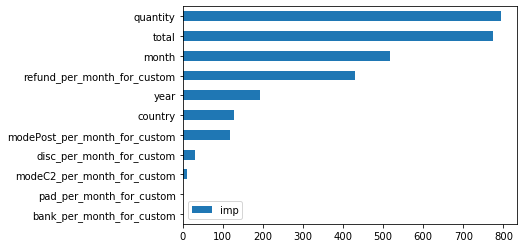

In [164]:
model = LGBMClassifier(random_state=1234)
model.fit(X_train, y_train)
pd.DataFrame(model.feature_importances_, index = X_train.columns, columns = ['imp']).sort_values('imp').plot(kind = 'barh')

=> 대체로 tree 계열이 결과가 좋은듯 -> 묶어서 stacking 진행해보자

In [157]:
estimators = [
            ('gbm', GradientBoostingClassifier(random_state=1234)),
            ('xgb', XGBClassifier(random_state=1234)), 
            ('lgbm', LGBMClassifier(random_state=1234))
            ]
 
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, y_train)

StackingClassifier(estimators=[('gbm',
                                GradientBoostingClassifier(random_state=1234)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None, gamma=None,
                                              gpu_id=None,
                                              importance_type='gain',
                                              interaction_constraints=None,
                                              learning_rate=None,
                                              max_delta_step=None,
                                              max_depth=None,
                                              min_child_weight=None,
                                              missing=nan,
                 

In [158]:
score = cross_val_score(clf, X_train, y_train, cv=5, scoring=make_scorer(roc_auc_score))
print('CV-score: ', score)
print('mean(CV-score): ', score.mean())

CV-score:  [0.69108923 0.70006805 0.7206013  0.7073195  0.73044003]
mean(CV-score):  0.7099036208473603


==> 별차이 없음 -> 유의미한 변수를 추가하거나 하이퍼 파라미터 튜닝을 진행해야 할듯!

In [164]:
X_test['year'] = X_test['order_month'].apply(lambda x: int(x.split('-')[0]))
X_test['month'] = X_test['order_month'].apply(lambda x: int(x.split('-')[1]))
x_test = X_test.drop(['customer_id', 'order_month'], axis = 1)

y_pred = clf.predict_proba(x_test)
y_pred

C:\Users\seung\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\seung\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array([[0.10342907, 0.89657093],
       [0.10065642, 0.89934358],
       [0.9004097 , 0.0995903 ],
       ...,
       [0.87794869, 0.12205131],
       [0.85583447, 0.14416553],
       [0.10847936, 0.89152064]])

In [165]:
pred = pd.DataFrame(X_test['customer_id']).reset_index(drop = True)
pred['probability'] = list(map(lambda x: x[1], y_pred))
pred

,customer_id,probability
0,12349,0.896571
1,12352,0.899344
2,12356,0.099590
3,12357,0.901662
4,12362,0.906099
...,...,...
1703,18263,0.900440
1704,18270,0.142778
1705,18274,0.122051
1706,18276,0.144166


In [166]:
print('test set의 # unique customer_id:', test['customer_id'].nunique())

test set의 # unique customer_id: 5914


In [167]:
print('train set의 # unique customer_id: ', train.loc[train['order_month'] == '2011-11']['customer_id'].nunique())

train set의 # unique customer_id:  1708


==> sample_submission.csv의 customer_id가 2011-11월의 존재하는 customer_id보다 많음...;; -> 일단 pred 저장

In [168]:
pred.to_csv('submission.csv', index = False)